# Multi Color Light Curves  applied to LATISS DZP on CCD




- author Sylvie Dagoret-Campagne
- creation date 2024-05-03
- last update 2024-05-05

w_2024_16
  
``Quantum Graphs``: https://tigress-web.princeton.edu/~lkelvin/pipelines/ 


https://tigress-web.princeton.edu/~lkelvin/pipelines/current/drp_pipe/LSSTComCamSim/nightly-validation-ops-rehearsal-3/

``CalibrateTask``: 
https://github.com/lsst/pipe_tasks/blob/main/python/lsst/pipe/tasks/calibrate.py#L392-L399


``Shemas``:
https://dm.lsst.org/sdm_schemas/browser/

In [1]:
from lsst.daf.butler import Butler

import astropy.units as u
import numpy as np 
import pandas as pd
pd.set_option("display.max_columns", None)
from astropy.time import Time

import scipy.stats

import matplotlib
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm

import lsst.afw.display.rgb as afwRgb
import lsst.afw.image as afwImage
import lsst.geom as geom
import pickle
from astropy.stats import SigmaClip

In [2]:
#xx-small
#x-small
#small
#medium
#large
#x-large
#xx-large

plt.rcParams["figure.figsize"] = (10,6)
plt.rcParams["axes.labelsize"] = 'x-large'
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['xtick.labelsize']= 'x-large'
plt.rcParams['ytick.labelsize']= 'x-large'

In [3]:
from shapely.geometry import Point as shapelyPoint
from shapely.geometry.polygon import Polygon as shapelyPolygon

In [4]:
def is_in_polygon(x,y,ll,lr,ur,ul):
    point = shapelyPoint(x, y)
    polygon = shapelyPolygon([ll, lr, ur, ul])
    return polygon.contains(point)

In [5]:
def angle_in_range(alpha, lower, upper):
    return (alpha - lower) % 360 <= (upper - lower) % 360

In [6]:
def isradec_inbbox_radec(ra,dec,ramin,ramax,decmin,decmax):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    ra: ra in degree
    dec: dec in degree
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    Bool
    
    """


    flag_ra = angle_in_range(ra,ramin,ramax)
    flag_dec = angle_in_range(dec,decmin,decmax)

    flag = flag_ra and flag_dec
    return flag


In [7]:
def get_corners_radec(wcs, bbox):
    """
    Return the corners in RA,Dec in degrees given the WCS and bounding box for an image.

    Parameters
    ----------
    wcs: image WCS returned by the Butler
    bbox: bounding box returned by the Butler

    Returns
    -------
    corners_ra, corners_dec in decimal degrees
    """

    corners_x = [bbox.beginX, bbox.beginX, bbox.endX, bbox.endX]
    corners_y = [bbox.beginY, bbox.endY, bbox.endY, bbox.beginY]
    corners_ra = []
    corners_dec = []
    for i in range(4):
        radec = wcs.pixelToSky(corners_x[i], corners_y[i])
        corners_ra.append(radec.getRa().asDegrees())
        corners_dec.append(radec.getDec().asDegrees())
    
    return corners_ra, corners_dec

In [8]:
saveDir = "./lc_output_dmrehearsal2024-latiss"
doSaveFigs = False  # set to True if you actually want to save the figures in the above dir

In [9]:
# Set some selections for reliable data
minNumMatches = 3
minSnCalibFlux =  50 #100

In [10]:
# INSERT YOUR collection and tract
# for rehearsal use collection 2 which have CCDvisit
butlerRoot = "/repo/embargo"

collection1 = 'LSSTComCamSim/runs/nightlyvalidation/20240402/d_2024_03_29/DM-43612'
collection2 = 'LSSTComCamSim/runs/nightlyvalidation/20240403/d_2024_03_29/DM-43612'
collection3 = 'LSSTComCamSim/runs/nightlyvalidation/20240404/d_2024_03_29/DM-43612'
collection = 'LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985'
collectionn = collection
#collections = [collection1,collection2,collection3]
collections = [collection]
collectionStr = collectionn.replace("/", "_")
instrument = 'LATISS'
skymapName = "latiss_v1"
where_clause = "instrument = \'" + instrument+ "\'"
tract = 3864 # mostly for light-curves
#tract = 5615
# tract = 5634 # interesting to view calib parameters
suptitle = collectionStr + f" inst = {instrument} tract = {tract}"

calibFluxStr = "apFlux_35_0_instFlux"
calibFluxErrStr = "apFlux_35_0_instFluxErr"
calibFluxMagStr = "apFlux_35_0_instMag"
calibFluxMagErrStr = "apFlux_35_0_instMagErr"

calibFluxCalStr = "apFlux_35_0_calFlux"
calibFluxCalErrStr = "apFlux_35_0_calFluxErr"
calibFluxCalMagStr = "apFlux_35_0_calMag"
calibFluxCalMagErrStr = "apFlux_35_0_calMagErr"

file_output_selectedsources = f"lightcurves-dmrehearsal2024_04_03-latiss-tract{tract}.csv"
fullname_file_output_selectedsources = os.path.join(saveDir,file_output_selectedsources)

## Initiate butler from variables set above

In [11]:
# Initiate butler from variables set above
butler = Butler(butlerRoot, collections=collections, instrument=instrument, skymap=skymapName)
camera = butler.get("camera", instrument=instrument)
skymap = butler.get("skyMap")
print("camera_name = {}".format(camera.getName()))
print("collections = {}".format(collections))

camera_name = LATISS
collections = ['LATISS/runs/AUXTEL_DRP_IMAGING_20230509_20240311/w_2024_10/PREOPS-4985']


## load isolated_star_sources

In [12]:
# Try to get the Schema
all_tracts = []
data_product = "isolated_star_sources"
datasetRefs = butler.registry.queryDatasets(datasetType=data_product, collections=collections, where= where_clause)
for i, ref in enumerate(datasetRefs):
    print(i,ref.dataId)
    all_tracts.append(ref.dataId["tract"])
    #butler_data = butler.get(ref)

all_tracts = sorted(all_tracts)
print("all tracts : ", all_tracts)

#if not isinstance(butler_data, pd.core.frame.DataFrame):
#    print(butler_data.getSchema())

0 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 380}
1 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 382}
2 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 383}
3 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 452}
4 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 454}
5 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 455}
6 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 3863}
7 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 3864}
8 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 5614}
9 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 5615}
10 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 5616}
11 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 5634}
12 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 5839}
13 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 8188}
14 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 10643}
15 {instrument: 'LATISS', skymap: 'latiss_v1', tract: 10644}
all tracts :  [380, 382, 383, 452, 454, 455, 3863, 386

## isolated_star_sources Keeping all bands here, but keep the tract selection

The main starting point is the table of isolated_star_sources which has been constructed in step 2a from a catalog
Note that isolated star sources are associated to an object (a static starobject)
Here the work is doneband by band.
It is a good idea to work band by band.

In [13]:
# Load in isolated_star_sources and trim to band of interest and select the tract
isolatedStarSourcesFull = butler.get("isolated_star_sources", tract=tract)
#isolatedStarSourcesFull = isolatedStarSourcesFull[isolatedStarSourcesFull["band"] == band]

In [14]:
tract

3864

In [15]:
len(isolatedStarSourcesFull)

163861

In [16]:
# Just to have a look at what's in the catalog:
isolatedStarSourcesFull[isolatedStarSourcesFull.index == 0]

,index,sourceId,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index
0,720,178244558356742865,2023111500493,0,122.502818,-36.181373,empty~SDSSi_65mm,i,17929.311148,580.063968,3089.020434,3522.956779,18544.821571,817.794717,False,-0.084691,False,720,0


In [17]:
isolatedStarSourcesFull.head()

,index,sourceId,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index
0,720,178244558356742865,2023111500493,0,122.502818,-36.181373,empty~SDSSi_65mm,i,17929.311148,580.063968,3089.020434,3522.956779,18544.821571,817.794717,False,-0.084691,False,720,0
1,657,178244564799193746,2023111500499,0,122.502820,-36.181372,empty~SDSSi_65mm,i,17965.443097,593.565729,1981.052932,3539.433919,18788.373258,839.011243,False,0.049484,False,657,0
2,690,178244568020419251,2023111500502,0,122.502819,-36.181372,empty~SDSSi_65mm,i,17309.856495,581.983397,1425.831515,3545.340924,17906.736267,821.413552,False,0.070277,False,690,0
3,481,178244580905320930,2023111500514,0,122.502817,-36.181374,empty~SDSSi_65mm,i,16563.487123,545.671588,3634.994108,2036.356179,16308.805325,776.241811,False,-0.196106,False,481,0
4,432,178244587347771825,2023111500520,0,122.502822,-36.181372,empty~SDSSi_65mm,i,17951.820662,577.548601,2527.386039,2051.742380,18624.356145,814.688326,False,0.041315,False,432,0


In [18]:
isolatedStarSourcesFull.tail()

,index,sourceId,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index
163856,56,179546353280483385,2023122200468,0,122.636922,-36.166699,empty~SDSSy_65mm,y,6159.305843,570.340900,4029.261883,467.716012,NaN,NaN,True,-0.120178,False,56,1298
163857,6,178913118334746631,2023120400546,0,122.627449,-36.261951,empty~SDSSy_65mm,y,6002.652226,546.429347,3854.516501,69.447705,5149.290161,779.662392,False,-0.179842,False,6,1299
163858,289,181973644384141602,2024022900067,0,122.439252,-36.069256,empty~SDSSy_65mm,y,17046.173911,591.284537,1160.102547,3639.086131,19346.313383,837.526273,False,0.166535,False,289,1300
163859,311,181973652974076216,2024022900075,0,122.477861,-36.067847,empty~SDSSy_65mm,y,17262.146455,589.125479,1210.733303,3710.297643,17597.427159,831.424850,False,0.083739,False,311,1301
163860,149,179159378874597526,2023121100518,0,122.371089,-36.241101,empty~SDSSy_65mm,y,6536.212928,607.428677,112.776400,984.505377,7636.402888,864.654488,False,0.303516,False,149,1302


In [19]:
isolatedStarSourcesFull.columns

Index(['index', 'sourceId', 'visit', 'detector', 'ra', 'dec',
       'physical_filter', 'band', 'apFlux_35_0_instFlux',
       'apFlux_35_0_instFluxErr', 'x', 'y', 'apFlux_50_0_instFlux',
       'apFlux_50_0_instFluxErr', 'apFlux_50_0_flag',
       'localBackground_instFlux', 'localBackground_flag', 'source_row',
       'obj_index'],
      dtype='object')

In [20]:
#print(sorted(isolatedStarSourcesFull["visit"].unique()))

In [21]:
# Just to have a look at what's in the catalog:
isolatedStarSourcesFull[isolatedStarSourcesFull.index == 0]

,index,sourceId,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index
0,720,178244558356742865,2023111500493,0,122.502818,-36.181373,empty~SDSSi_65mm,i,17929.311148,580.063968,3089.020434,3522.956779,18544.821571,817.794717,False,-0.084691,False,720,0


In [22]:
print("calibFluxStr = {},,minSnCalibFlux = {}, minNumMatches = {}".format(calibFluxStr,minSnCalibFlux,minNumMatches))

calibFluxStr = apFlux_35_0_instFlux,,minSnCalibFlux = 50, minNumMatches = 3


## Select a number of visits with enough good sources but in all bands here

- extract the list of known objects

In [23]:
calibFluxStr

'apFlux_35_0_instFlux'

In [24]:
minSnCalibFlux

50

In [25]:
# Trim the isolated_star_sources cat to those PSF S/N > minSnCalibFlux
# and number of matches sources > minNumMatches.
objIndexListFull = list(set(isolatedStarSourcesFull["obj_index"].values))

# Select the bright stars above a minimum of S/N ratio
if minSnCalibFlux is not None:
    snCalibFlux = isolatedStarSourcesFull[calibFluxStr]/isolatedStarSourcesFull[calibFluxStr + "Err"]
    snMask = snCalibFlux > minSnCalibFlux
    isolatedStarSourcesMinSn = isolatedStarSourcesFull[snMask].copy(deep=True)
else:
    isolatedStarSourcesMinSn = isolatedStarSourcesFull.copy(deep=True)

# object index with obj index in above selected bright selected star
objIndexListMinSn = list(set(isolatedStarSourcesMinSn["obj_index"].values))

# requires that the object is associated to several sources (at least minNumMatches sources)
# loop on object having sources with S/N aboe selection 
objIndexList = []
for objIndex in objIndexListMinSn:
    objData = isolatedStarSourcesMinSn[isolatedStarSourcesMinSn["obj_index"] == objIndex]
    if len(objData) >= minNumMatches:
        objIndexList.append(objIndex)
numTrimmed = len(objIndexListFull) - len(objIndexList)

mask = []
for objIndex, visit in zip(isolatedStarSourcesMinSn["obj_index"], isolatedStarSourcesMinSn["visit"]):
    if objIndex in objIndexList:
        mask.append(True)
    else:
        mask.append(False)
isolatedStarSources = isolatedStarSourcesMinSn[mask].copy(deep=True)

# Select a number of visits according quality criteria
visitList = list(set(isolatedStarSources["visit"].values))

if minSnCalibFlux is not None:
    print("Trimmed isolated_star_sources catalog to S/N {} > {} (leaving N={} matched sources from original {})".format(
        calibFluxStr, minSnCalibFlux, len(isolatedStarSources), len(isolatedStarSourcesFull)))
print("Trimmed isolated_star_sources catalog to objecst with nMatches >= {} (leaving {} objects from {}).".format(
    minNumMatches, len(objIndexList), len(objIndexListFull)))

Trimmed isolated_star_sources catalog to S/N apFlux_35_0_instFlux > 50 (leaving N=47325 matched sources from original 163861)
Trimmed isolated_star_sources catalog to objecst with nMatches >= 3 (leaving 355 objects from 1303).


In [26]:
sorted_visitList = sorted(visitList)
#sorted_visitList 

In [27]:
def convertVisitToDatestr(visit):

    num = visit//100_000
    year = num//10_000
    month= (num-year*10_000)//100
    day = (num-year*10_000-month*100)

    year_str = str(year).zfill(4)
    month_str = str(month).zfill(2)
    day_str = str(day).zfill(2)
    
    datestr = f"{year_str}-{month_str}-{day_str}"
    return datestr

In [28]:
def convertVisitToMJD(visit):
    return Time(convertVisitToDatestr(visit)).mjd

In [29]:
sorted_visits_mjd = list(map(convertVisitToMJD, sorted_visitList))

## sourceTable_visit

This is the main output of FGCM calibration which has selected a number of sources. These sources were originally selected from isolated sources.

In [30]:
# Extra columns to load from sourceTable_visit catalogs
names = ["psfFlux", "psfFluxErr", "psfFlux_flag", "psfFlux_apCorr", "psfFlux_apCorrErr",
         "extendedness", "detect_isPrimary", "deblend_skipped",
         "gaussianFlux", "gaussianFluxErr", "gaussianFlux_flag",
         "localPhotoCalib", "localPhotoCalibErr", "localPhotoCalib_flag"]

## Note that some sourceTable_visit not found for some visits in isolated_star_sources 

In [31]:
#visitList

In [32]:
# Load in the sourceTable_visit catalogs to get the psfFlux and other useful info per source.
# Columns loaded are those in names above.
# The selected sources from the sourceTable_visit will go in a list inside the sourceCatalog
sourceCatalogs = []
nSourceDict = {}
visitsToRemove = []

# loop over all selected visit and load sourceTable_visit visit per visit
for visit in visitList:
    try:
        sourceCatalogOrig = butler.get("sourceTable_visit", visit=visit, parameters={"columns": names})
        primaryCat = sourceCatalogOrig[sourceCatalogOrig["detect_isPrimary"]].copy(deep=True)
        nSourceDict[visit] = sum(primaryCat["psfFlux"]/primaryCat["psfFluxErr"] > 5)
        sourceCatalogs.append(primaryCat)
    except LookupError:
        print("sourceTable_visit not found for visit {}".format(visit))
        isolatedStarSources = isolatedStarSources[isolatedStarSources["visit"] != visit].copy(deep=True)
        visitsToRemove.append(visit)
visitList = list(set(visitList) - set(visitsToRemove))

# Do the minNumMatches cut again since visits may have been removed due to lack of sourceTable_visit
print("Number of objects with >=3 matches before sourceTable_visit exsistence check: {}".format(len(objIndexList)))
objIndexListAllNew = list(set(isolatedStarSources["obj_index"].values))
objIndexList = []
for objIndex in objIndexListAllNew:
    objData = isolatedStarSources[isolatedStarSources["obj_index"] == objIndex]
    if len(objData) >= minNumMatches:
        objIndexList.append(objIndex)
mask = []
for objIndex, visit in zip(isolatedStarSources["obj_index"], isolatedStarSources["visit"]):
    if objIndex in objIndexList:
        mask.append(True)
    else:
        mask.append(False)
isolatedStarSources = isolatedStarSources[mask].copy(deep=True)
visitList = list(set(isolatedStarSources["visit"].values))
print("Number of objects with >=3 matches after sourceTable_visit exsistence check: {}".format(len(objIndexList)))
dataJoined = pd.concat(sourceCatalogs).merge(isolatedStarSources, on="sourceId", how="inner")

sourceTable_visit not found for visit 2024030200023
sourceTable_visit not found for visit 2024030200026
sourceTable_visit not found for visit 2024030200034
sourceTable_visit not found for visit 2024030200038
sourceTable_visit not found for visit 2024030200043
sourceTable_visit not found for visit 2024030200049
sourceTable_visit not found for visit 2024030200050
sourceTable_visit not found for visit 2023112000360
sourceTable_visit not found for visit 2023112000367
sourceTable_visit not found for visit 2024020600055
sourceTable_visit not found for visit 2023113000525
sourceTable_visit not found for visit 2023113000529
sourceTable_visit not found for visit 2023113000528
sourceTable_visit not found for visit 2024012900356
sourceTable_visit not found for visit 2024022600054
sourceTable_visit not found for visit 2024022600055
sourceTable_visit not found for visit 2023111600631
sourceTable_visit not found for visit 2023111600638
sourceTable_visit not found for visit 2023111600640
sourceTable_

In [33]:
len(sourceCatalogs)

2521

In [34]:
#nSourceDict

In [35]:
#visitList

In [36]:
visitsToRemove 

[2024030200023,
 2024030200026,
 2024030200034,
 2024030200038,
 2024030200043,
 2024030200049,
 2024030200050,
 2023112000360,
 2023112000367,
 2024020600055,
 2023113000525,
 2023113000529,
 2023113000528,
 2024012900356,
 2024022600054,
 2024022600055,
 2023111600631,
 2023111600638,
 2023111600640,
 2023111600684,
 2023111600688,
 2023111600702,
 2023111600708,
 2024030700246,
 2024020700276,
 2024020700277,
 2024020700280,
 2024020700282,
 2024020700286,
 2024020700290,
 2024020700303,
 2024020700304,
 2024020700305,
 2024020700306,
 2024020700317,
 2024020700318,
 2024020700319,
 2024020700331,
 2024020700334,
 2024020700339,
 2024020700349,
 2024020700350,
 2024020700358,
 2024020800027,
 2024020800024,
 2024020800039,
 2024020800040,
 2024020800043,
 2024020800044,
 2024020800047,
 2024020800053,
 2024020800055,
 2024020800056,
 2024020800057,
 2024020800060,
 2024020800062,
 2024020800064,
 2024020800072,
 2023121900370,
 2024030200065,
 2024030200077,
 2024030200081,
 2024030

## Will start to work on dataJoined which associate selected "isolated_star_sources" in the selected band and visits the good calibration in "sourceTable_visit"

### retrieve the CCD Visit Table

- it provides airmass and initial zero-point

In [37]:
ccdVisitTable = butler.get("ccdVisitTable")

In [38]:
ccdVisitTable

,visitId,physical_filter,band,ra,dec,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec
ccdVisitId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
40919696896,2023051100262,SDSSr_65mm~empty,r,239.946728,-24.053747,56.749516,27.697306,7.760594,11.193549,7.856800,0.025776,0.014186,27,-0.002812,-0.001684,0.028204,0.007311,0.066781,0.043159,0.005508,0.449597,1922.977051,0.213347,0.016604,2.680115,0.159810,-24.053747,0,1.749004,322.911701,2023-05-12 01:08:56.302993,60076.047874,30.0,2023-05-12 01:08:41.302993,60076.047700,30.2434,4071,3999,239.935567,-24.128923,240.029265,-24.062575,239.957875,-23.978570,239.864202,-24.044874
40919697408,2023051100264,SDSSi_65mm~empty,i,239.938164,-24.036848,55.439133,27.838850,6.321881,28.073927,8.586373,0.026761,0.017073,36,0.004348,-0.017695,0.039457,0.038433,0.016566,0.088571,0.013995,0.303527,1387.484985,0.166373,0.025021,1.068607,0.207413,-24.036848,0,1.424821,170.004955,2023-05-12 01:15:04.912000,60076.052140,30.0,2023-05-12 01:14:49.912000,60076.051967,30.2335,4071,3999,239.985571,-23.974553,239.869115,-23.994653,239.890710,-24.099127,240.007258,-24.079012
40919698432,2023051100268,SDSSr_65mm~empty,r,239.964414,-24.045512,54.482189,27.716721,8.038972,10.700970,7.854424,0.024561,0.014016,15,0.000819,-0.009080,0.013239,0.003397,0.129652,0.081767,0.009968,0.387803,2265.302246,0.215552,0.015474,2.803484,0.165628,-24.045512,0,1.811649,323.867206,2023-05-12 01:19:39.311494,60076.055316,30.0,2023-05-12 01:19:24.311494,60076.055142,30.2379,4071,3999,239.951871,-24.120505,240.046767,-24.055593,239.976942,-23.970518,239.882074,-24.035387
40919698944,2023051100270,SDSSi_65mm~empty,i,239.961137,-24.046364,53.849274,27.858833,6.754847,23.952974,8.440454,0.023946,0.012757,24,-0.006401,0.005997,0.036388,0.022835,-0.003559,0.056631,0.008252,1.230267,2129.429688,0.177205,0.021916,1.252454,0.215191,-24.046364,0,1.522426,170.004124,2023-05-12 01:22:36.150002,60076.057363,30.0,2023-05-12 01:22:21.150002,60076.057189,30.2424,4071,3999,240.008535,-23.984061,239.892085,-24.004162,239.913693,-24.108652,240.030234,-24.088534
40919699200,2023051100271,SDSSi_65mm~empty,i,239.977384,-24.051453,53.394787,27.826286,6.488425,23.321407,8.416399,0.028203,0.012467,29,-0.001410,0.001387,0.026839,0.013898,0.008566,0.101609,0.015674,0.389506,1594.576904,0.185779,0.023753,1.286372,0.202669,-24.051453,0,1.462219,324.227336,2023-05-12 01:24:47.058502,60076.058878,30.0,2023-05-12 01:24:32.058502,60076.058704,30.2432,4071,3999,239.964342,-24.126362,240.059682,-24.062017,239.990410,-23.976542,239.895100,-24.040845
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43453134336,2024030800566,empty~SDSSy_65mm,y,122.493129,-36.203685,52.129131,26.166447,4.858362,13.559249,8.029708,0.016093,0.008375,56,0.003102,0.002562,0.026002,0.028631,0.004972,0.062312,0.012685,0.680248,1446.534058,0.026788,0.042366,2.212512,0.009526,-36.203685,0,1.094969,359.995886,2024-03-09 05:56:19.403505,60378.247447,30.0,2024-03-09 05:56:04.403505,60378.247273,30.2347,4071,3999,122.426835,-36.257489,122.561095,-36.256166,122.559331,-36.149845,122.425254,-36.151166
43453134592,2024030800567,SDSSg_65mm~empty,g,122.510609,-36.203581,52.449371,27.953827,6.890330,3.249260,7.539632,0.025825,0.014944,43,-0.006537,0.008663,0.023004,0.019870,0.002939,0.032655,0.004716,0.731599,1252.624023,1.495535,0.021063,9.232872,0.256341,-36.203581,0,1.553279,359.995708,2024-03-09 05:58:01.104

In [39]:
ccdVisitTable_subset = ccdVisitTable.iloc[:20][["visitId","detector","band"]]
ccdVisitTable_subset

,visitId,detector,band
ccdVisitId,,,
40919696896,2023051100262,0,r
40919697408,2023051100264,0,i
40919698432,2023051100268,0,r
40919698944,2023051100270,0,i
40919699200,2023051100271,0,i
40919699712,2023051100273,0,r
40919699968,2023051100274,0,r
40919700480,2023051100276,0,i
40919700736,2023051100277,0,i


In [40]:
ccdVisitTable.groupby(["visitId","ccdVisitId","detector"]).size()

visitId        ccdVisitId   detector
2023051100262  40919696896  0           1
2023051100264  40919697408  0           1
2023051100268  40919698432  0           1
2023051100270  40919698944  0           1
2023051100271  40919699200  0           1
                                       ..
2024030800566  43453134336  0           1
2024030800567  43453134592  0           1
2024030800568  43453134848  0           1
2024030800569  43453135104  0           1
2024030800570  43453135360  0           1
Length: 3993, dtype: int64

In [41]:
for visit in visitList:
    if visit in ccdVisitTable["visitId"].values:
        print(ccdVisitTable[ccdVisitTable["visitId"] == visit]["zeroPoint"])
        print(ccdVisitTable[ccdVisitTable["visitId"] == visit]["detector"])
        break

ccdVisitId
42748468736    27.28923
Name: zeroPoint, dtype: float32
ccdVisitId
42748468736    0
Name: detector, dtype: int64


In [42]:
ccdVisitTable["airmass"] = ccdVisitTable["zenithDistance"].apply(lambda x: 1/np.cos(np.pi/180.*x))
ccdVisitTable["medianE"] = np.sqrt(ccdVisitTable["psfStarDeltaE1Median"] ** 2.0 + ccdVisitTable["psfStarDeltaE2Median"] ** 2.0)

In [43]:
# Collect useful columns from ccdVisitTable
# This is wrong when we have several detectors per visit
if 0:
    visitsCCDToRemove = []

    #Note there is one value per detector
    psfSigmaDict = {}
    skyBgDict = {}
    skyNoiseDict = {}
    expTimeDict = {}
    expMidptMjdDict = {}
    medianEDict = {}
    psfStarScaledDeltaSizeScatterDict = {}
    astromOffsetStdDict = {}
    psfTraceRadiusDeltaDict = {}
    zeroPointDict = {}
    airmassDict = {}
    seeingDict = {}

    # for visit in ccdVisitTable["visitId"].values:
    #     if visit in visitList:
    for visit in visitList:
        if visit in ccdVisitTable["visitId"].values:
            psfSigmaDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["psfSigma"].values[0]
            skyBgDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["skyBg"].values[0]
            skyNoiseDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["skyNoise"].values[0]
            expTimeDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["expTime"].values[0]
            expMidptMjdDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["expMidptMJD"].values[0]
            medianEDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["medianE"].values[0]
            psfStarScaledDeltaSizeScatterDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["psfStarScaledDeltaSizeScatter"].values[0]
            astromOffsetStdDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["astromOffsetStd"].values[0]
            psfTraceRadiusDeltaDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["psfTraceRadiusDelta"].values[0]
            zeroPointDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["zeroPoint"].values[0]
            airmassDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["airmass"].values[0]
            seeingDict[visit] = ccdVisitTable[ccdVisitTable["visitId"] == visit]["seeing"].values[0]

        else:
            #raise RuntimeError("ERROR: visit {} not found in ccdVisitTable".format(visit))
            print("ERROR: CCD visit {} not found in ccdVisitTable".format(visit))
            visitsCCDToRemove.append(visit) 
            psfSigmaDict[visit] = np.nan
            skyBgDict[visit] = np.nan
            skyNoiseDict[visit] = np.nan
            expTimeDict[visit] = np.nan
            expMidptMjdDict[visit] = np.nan
            medianEDict[visit] = np.nan
            psfStarScaledDeltaSizeScatterDict[visit] = np.nan
            astromOffsetStdDict[visit] = np.nan
            psfTraceRadiusDeltaDict[visit] = np.nan
            zeroPointDict[visit] = np.nan
            airmassDict[visit] = np.nan
            seeingDict[visit] = np.nan

In [44]:
#visitList

In [45]:
#visitsToRemove 

In [46]:
# Just to have a look at what's in the catalog:
#ccdVisitTable[ccdVisitTable.index == ccdVisitTable.index[0]] 

### Plot visits versus time

In [47]:
ccdVisitTable_subset = ccdVisitTable[["visitId","band","zeroPoint","psfSigma","skyBg","skyNoise","seeing","expMidptMJD","obsStart","airmass","llcra","llcdec","ulcra","ulcdec","urcra","urcdec","lrcra","lrcdec"]]

#### compute nightObs and datetime time

In [48]:
ccdVisitTable_subset["nightObs"] =ccdVisitTable_subset.apply(lambda x: x['visitId']//100_000, axis=1)
ccdVisitTable_subset["Time"] = pd.to_datetime(ccdVisitTable_subset['obsStart'])

/tmp/ipykernel_38358/2741161870.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccdVisitTable_subset["nightObs"] =ccdVisitTable_subset.apply(lambda x: x['visitId']//100_000, axis=1)
/tmp/ipykernel_38358/2741161870.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccdVisitTable_subset["Time"] = pd.to_datetime(ccdVisitTable_subset['obsStart'])


In [49]:
ccdVisitTable_g = ccdVisitTable_subset[ccdVisitTable_subset.band== "g"]
ccdVisitTable_r = ccdVisitTable_subset[ccdVisitTable_subset.band== "r"]
ccdVisitTable_i = ccdVisitTable_subset[ccdVisitTable_subset.band== "i"]
ccdVisitTable_z = ccdVisitTable_subset[ccdVisitTable_subset.band== "z"]
ccdVisitTable_y = ccdVisitTable_subset[ccdVisitTable_subset.band== "y"]

In [50]:
ccdVisitTable_subset.head()

,visitId,band,zeroPoint,psfSigma,skyBg,skyNoise,seeing,expMidptMJD,obsStart,airmass,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,nightObs,Time
ccdVisitId,,,,,,,,,,,,,,,,,,,,
40919696896,2023051100262,r,27.697306,7.760594,11.193549,7.856800,1.749004,60076.047874,2023-05-12 01:08:41.302993,1.823818,239.935567,-24.128923,240.029265,-24.062575,239.957875,-23.978570,239.864202,-24.044874,20230511,2023-05-12 01:08:41.302993
40919697408,2023051100264,i,27.838850,6.321881,28.073927,8.586373,1.424821,60076.052140,2023-05-12 01:14:49.912000,1.762794,239.985571,-23.974553,239.869115,-23.994653,239.890710,-24.099127,240.007258,-24.079012,20230511,2023-05-12 01:14:49.912000
40919698432,2023051100268,r,27.716721,8.038972,10.700970,7.854424,1.811649,60076.055316,2023-05-12 01:19:24.311494,1.721301,239.951871,-24.120505,240.046767,-24.055593,239.976942,-23.970518,239.882074,-24.035387,20230511,2023-05-12 01:19:24.311494
40919698944,2023051100270,i,27.858833,6.754847,23.952974,8.440454,1.522426,60076.057363,2023-05-12 01:22:21.150002,1.695170,240.008535,-23.984061,239.892085,-24.004162,239.913693,-24.108652,240.030234,-24.088534,20230511,2023-05-12 01:22:21.150002
40919699200,2023051100271,i,27.826286,6.488425,23.321407,8.416399,1.462219,60076.058878,2023-05-12 01:24:32.058502,1.677014,239.964342,-24.126362,240.059682,-24.062017,239.990410,-23.976542,239.895100,-24.040845,20230511,2023-05-12 01:24:32.058502


In [51]:
ccdVisitTable_subset.tail()

,visitId,band,zeroPoint,psfSigma,skyBg,skyNoise,seeing,expMidptMJD,obsStart,airmass,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,nightObs,Time
ccdVisitId,,,,,,,,,,,,,,,,,,,,
43453134336,2024030800566,y,26.166447,4.858362,13.559249,8.029708,1.094969,60378.247447,2024-03-09 05:56:04.403505,1.628972,122.426835,-36.257489,122.561095,-36.256166,122.559331,-36.149845,122.425254,-36.151166,20240308,2024-03-09 05:56:04.403505
43453134592,2024030800567,g,27.953827,6.890330,3.249260,7.539632,1.553279,60378.248624,2024-03-09 05:57:46.104001,1.640791,122.444307,-36.257399,122.578585,-36.256079,122.576821,-36.149726,122.442725,-36.151044,20240308,2024-03-09 05:57:46.104001
43453134848,2024030800568,r,27.774017,6.158408,6.951125,7.735226,1.388087,60378.249164,2024-03-09 05:58:32.775498,1.646516,122.444537,-36.257436,122.578805,-36.256104,122.577046,-36.149772,122.442960,-36.151103,20240308,2024-03-09 05:58:32.775498
43453135104,2024030800569,z,27.314375,5.293322,16.513548,8.214679,1.193113,60378.249704,2024-03-09 05:59:19.465993,1.652293,122.444783,-36.257474,122.579046,-36.256150,122.577282,-36.149812,122.443202,-36.151133,20240308,2024-03-09 05:59:19.465993
43453135360,2024030800570,y,26.234928,5.417888,14.284846,8.045543,1.221227,60378.250260,2024-03-09 06:00:07.432002,1.658276,122.445158,-36.257498,122.579434,-36.256166,122.577677,-36.149831,122.443583,-36.151162,20240308,2024-03-09 06:00:07.432002


### Search for removed visit in CCD Visit Tables

In [52]:
ccdVisitTable_subset["removed"] = ccdVisitTable_subset["visitId"].apply(lambda x: True if x in visitsToRemove else False) 
ccdVisitTable_subset_removed = ccdVisitTable_subset[ccdVisitTable_subset["removed"]] 
ccdVisitTable_subset_removed 

/tmp/ipykernel_38358/1432482308.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ccdVisitTable_subset["removed"] = ccdVisitTable_subset["visitId"].apply(lambda x: True if x in visitsToRemove else False)


,visitId,band,zeroPoint,psfSigma,skyBg,skyNoise,seeing,expMidptMJD,obsStart,airmass,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,nightObs,Time,removed
ccdVisitId,,,,,,,,,,,,,,,,,,,,,


#### Thus the visit IN isolated-star_sources and MISSING in sourceTable are also NOT in ccdVisitTable !!!

In [53]:
# function of time conversion
from astropy.time import Time

def dt_to_mjd(dt):
    t = Time(dt)
    return t.to_value('mjd','float')

def mjd_to_dt(mjd):
    tm = Time(mjd, format='mjd')
    # Convert to datetime
    utc =tm.to_datetime()
    return utc

In [54]:
dt = ccdVisitTable_subset.iloc[0]['Time']
dt

Timestamp('2023-05-12 01:08:41.302993')

In [55]:
type(dt)

pandas._libs.tslibs.timestamps.Timestamp

In [56]:
mjd = dt_to_mjd(dt)
mjd

60076.04770026612

In [57]:
tm = mjd_to_dt(mjd)

In [58]:
#ax.secondary_xaxis?

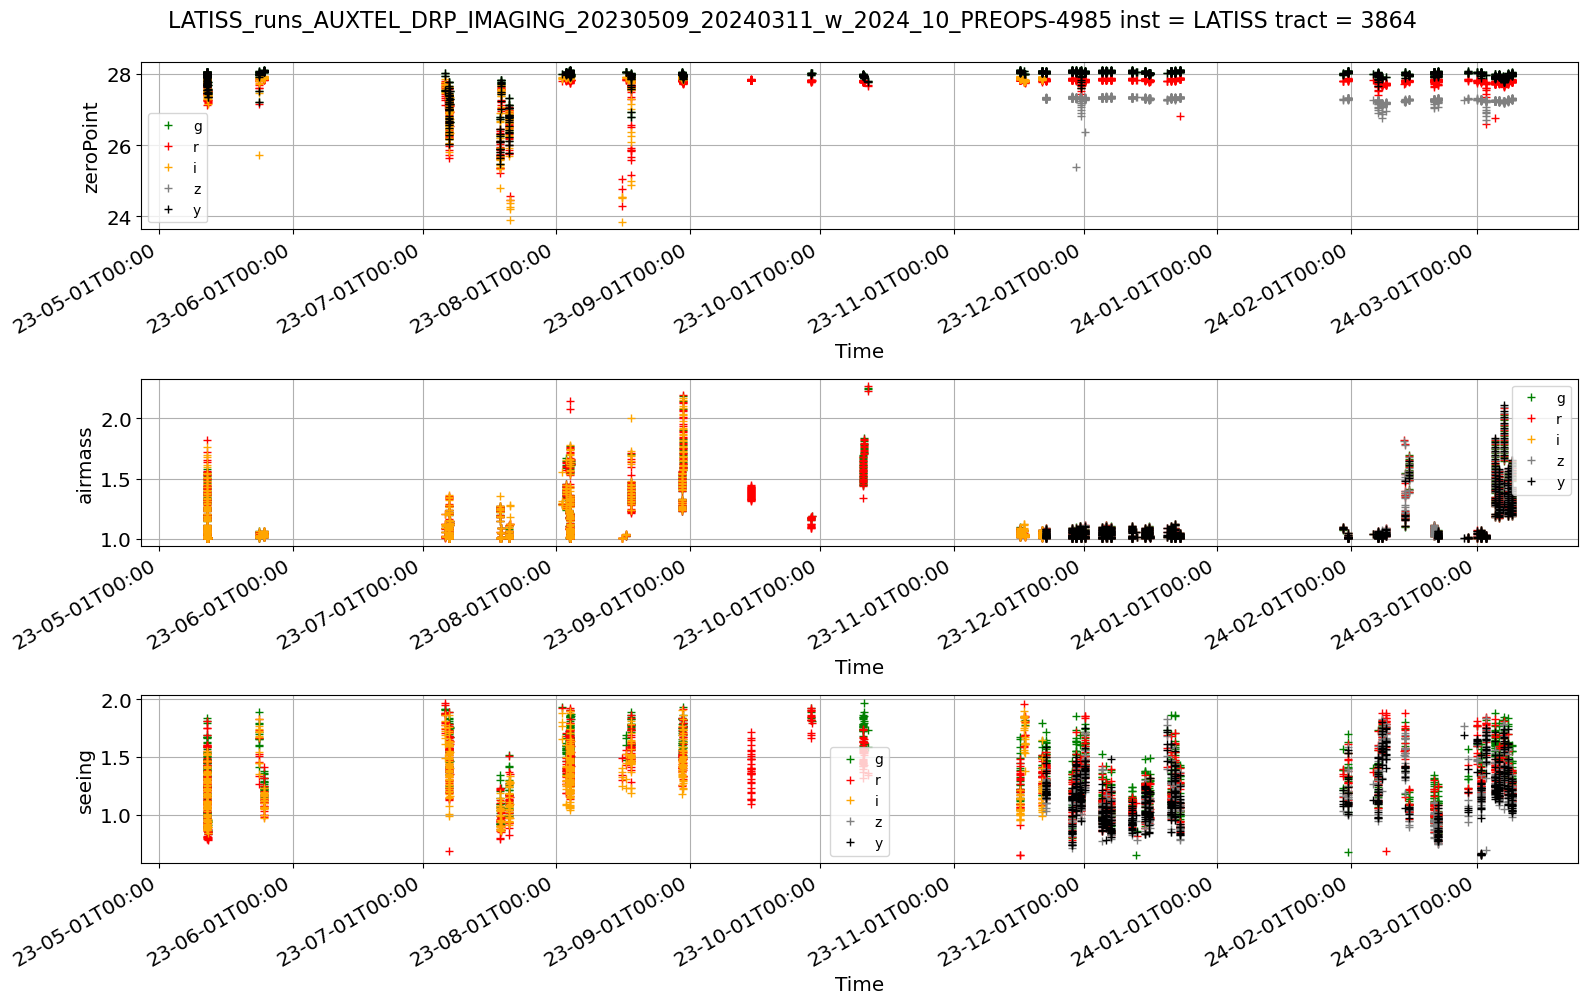

In [59]:
from matplotlib.dates import DateFormatter
date_form = DateFormatter("%y-%m-%dT%H:%M")

fig,axs = plt.subplots(3,1,figsize=(16,10))
ax1,ax2,ax3 = axs
ccdVisitTable_g.plot(x="Time",y="zeroPoint",marker='+',c="g",lw=0.0,ax=ax1,grid=True,label="g")
ccdVisitTable_r.plot(x="Time",y="zeroPoint",marker='+',c="r",lw=0.0,ax=ax1,grid=True,label="r")
ccdVisitTable_i.plot(x="Time",y="zeroPoint",marker='+',c="orange",lw=0.0,ax=ax1,grid=True,label="i")
ccdVisitTable_z.plot(x="Time",y="zeroPoint",marker='+',c="grey",lw=0.0,ax=ax1,grid=True,label="z")
ccdVisitTable_g.plot(x="Time",y="zeroPoint",marker='+',c="k",lw=0.0,ax=ax1,grid=True,label="y")
ax1.set_ylabel("zeroPoint")
ax1.xaxis.set_major_formatter(date_form)
#ax1_up = ax1.secondary_xaxis("top", functions=( dt_to_mjd, mjd_to_dt))
#ccdVisitTable_g.plot(x="expMidptMJD",y="zeroPoint",marker='+',c="g",lw=0.0,ax=ax1_up,grid=True,label="g")


ccdVisitTable_g.plot(x="Time",y="airmass",marker='+',c="g",lw=0.0,ax=ax2,grid=True,label="g")
ccdVisitTable_r.plot(x="Time",y="airmass",marker='+',c="r",lw=0.0,ax=ax2,grid=True,label="r")
ccdVisitTable_i.plot(x="Time",y="airmass",marker='+',c="orange",lw=0.0,ax=ax2,grid=True,label="i")
ccdVisitTable_z.plot(x="Time",y="airmass",marker='+',c="grey",lw=0.0,ax=ax2,grid=True,label="z")
ccdVisitTable_y.plot(x="Time",y="airmass",marker='+',c="k",lw=0.0,ax=ax2,grid=True,label="y")
ax2.set_ylabel("airmass")
ax2.xaxis.set_major_formatter(date_form)

ccdVisitTable_g.plot(x="Time",y="seeing",marker='+',c="g",lw=0.0,ax=ax3,grid=True,label="g")
ccdVisitTable_r.plot(x="Time",y="seeing",marker='+',c="r",lw=0.0,ax=ax3,grid=True,label="r")
ccdVisitTable_i.plot(x="Time",y="seeing",marker='+',c="orange",lw=0.0,ax=ax3,grid=True,label="i")
ccdVisitTable_z.plot(x="Time",y="seeing",marker='+',c="grey",lw=0.0,ax=ax3,grid=True,label="z")
ccdVisitTable_y.plot(x="Time",y="seeing",marker='+',c="k",lw=0.0,ax=ax3,grid=True,label="y")
ax3.set_ylabel("seeing")
ax3.xaxis.set_major_formatter(date_form)




#df.plot(x="Time",y="coord_dec",marker='o',c="g",lw=0.0,ax=ax2,grid=True)
plt.suptitle(suptitle,y=1.0,fontsize=16)
plt.tight_layout()



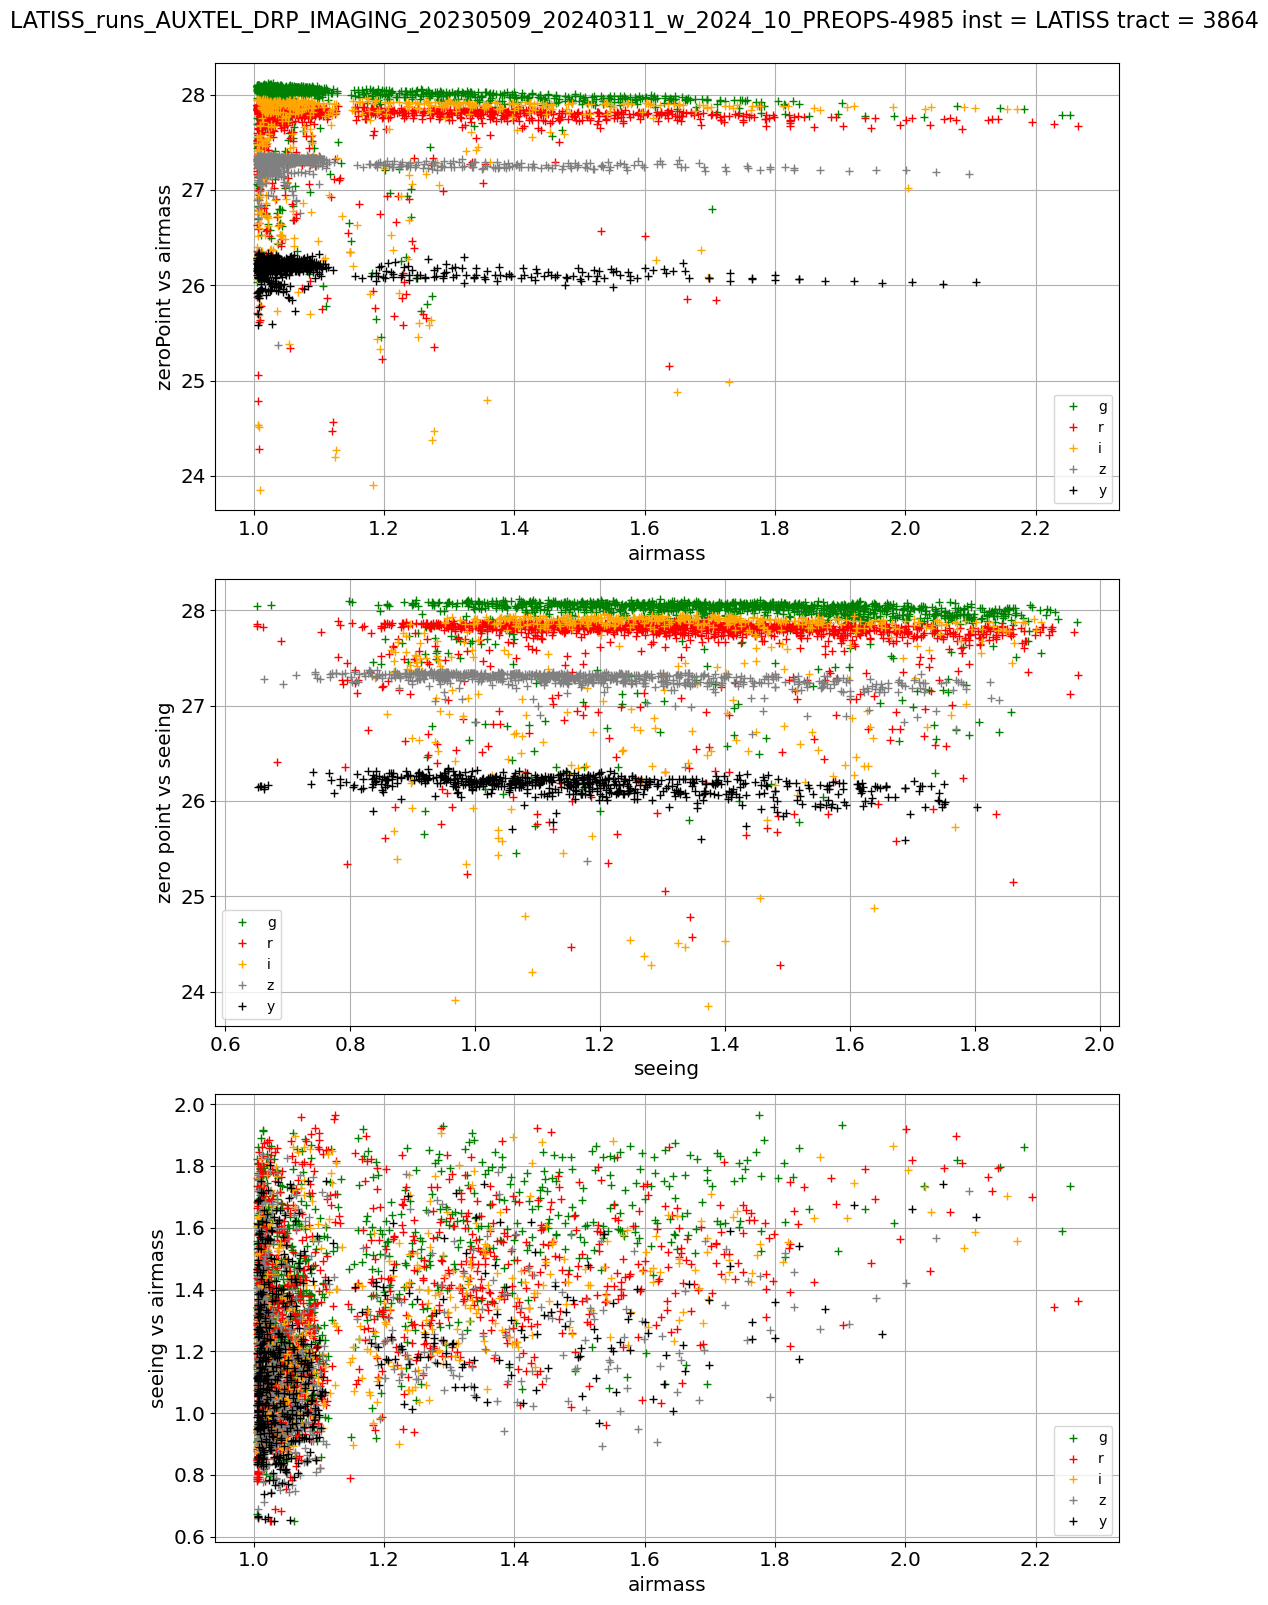

In [60]:
fig,axs = plt.subplots(3,1,figsize=(10,16))
ax1,ax2,ax3 = axs
ccdVisitTable_g.plot(x="airmass",y="zeroPoint",marker='+',c="g",lw=0.0,ax=ax1,grid=True,label="g")
ccdVisitTable_r.plot(x="airmass",y="zeroPoint",marker='+',c="r",lw=0.0,ax=ax1,grid=True,label="r")
ccdVisitTable_i.plot(x="airmass",y="zeroPoint",marker='+',c="orange",lw=0.0,ax=ax1,grid=True,label="i")
ccdVisitTable_z.plot(x="airmass",y="zeroPoint",marker='+',c="grey",lw=0.0,ax=ax1,grid=True,label="z")
ccdVisitTable_y.plot(x="airmass",y="zeroPoint",marker='+',c="k",lw=0.0,ax=ax1,grid=True,label="y")
ax1.set_ylabel("zeroPoint vs airmass")
#ax1_up = ax1.secondary_xaxis("top", functions=( dt_to_mjd, mjd_to_dt))
#ccdVisitTable_g.plot(x="expMidptMJD",y="zeroPoint",marker='+',c="g",lw=0.0,ax=ax1_up,grid=True,label="g")

ccdVisitTable_g.plot(x="seeing",y="zeroPoint",marker='+',c="g",lw=0.0,ax=ax2,grid=True,label="g")
ccdVisitTable_r.plot(x="seeing",y="zeroPoint",marker='+',c="r",lw=0.0,ax=ax2,grid=True,label="r")
ccdVisitTable_i.plot(x="seeing",y="zeroPoint",marker='+',c="orange",lw=0.0,ax=ax2,grid=True,label="i")
ccdVisitTable_z.plot(x="seeing",y="zeroPoint",marker='+',c="grey",lw=0.0,ax=ax2,grid=True,label="z")
ccdVisitTable_y.plot(x="seeing",y="zeroPoint",marker='+',c="k",lw=0.0,ax=ax2,grid=True,label="y")
ax2.set_ylabel("zero point vs seeing")

ccdVisitTable_g.plot(x="airmass",y="seeing",marker='+',c="g",lw=0.0,ax=ax3,grid=True,label="g")
ccdVisitTable_r.plot(x="airmass",y="seeing",marker='+',c="r",lw=0.0,ax=ax3,grid=True,label="r")
ccdVisitTable_i.plot(x="airmass",y="seeing",marker='+',c="orange",lw=0.0,ax=ax3,grid=True,label="i")
ccdVisitTable_z.plot(x="airmass",y="seeing",marker='+',c="grey",lw=0.0,ax=ax3,grid=True,label="z")
ccdVisitTable_y.plot(x="airmass",y="seeing",marker='+',c="k",lw=0.0,ax=ax3,grid=True,label="y")
ax3.set_ylabel("seeing vs airmass")

#df.plot(x="Time",y="coord_dec",marker='o',c="g",lw=0.0,ax=ax2,grid=True)
plt.suptitle(suptitle,y=1.0,fontsize=16)
plt.tight_layout()

## Come-back to dataJoined

In [61]:
dataJoined.columns

Index(['sourceId', 'psfFlux', 'psfFluxErr', 'psfFlux_flag', 'psfFlux_apCorr',
       'psfFlux_apCorrErr', 'extendedness', 'detect_isPrimary',
       'deblend_skipped', 'gaussianFlux', 'gaussianFluxErr',
       'gaussianFlux_flag', 'localPhotoCalib', 'localPhotoCalibErr',
       'localPhotoCalib_flag', 'index', 'visit', 'detector', 'ra', 'dec',
       'physical_filter', 'band', 'apFlux_35_0_instFlux',
       'apFlux_35_0_instFluxErr', 'x', 'y', 'apFlux_50_0_instFlux',
       'apFlux_50_0_instFluxErr', 'apFlux_50_0_flag',
       'localBackground_instFlux', 'localBackground_flag', 'source_row',
       'obj_index'],
      dtype='object')

### recalculate sources properties inside dataJoined before adding CCDVisit info

In [62]:
# Add columns into dataJoined table to have them all in one place
dataJoined["psfSn"] = dataJoined["psfFlux"]/dataJoined["psfFluxErr"]
dataJoined["psfMag"] = (dataJoined["psfFlux"].values*u.nJy).to(u.ABmag).value
dataJoined["psfMagErr"] = 2.5/np.log(10.0)*(dataJoined["psfFluxErr"].values/dataJoined["psfFlux"].values)

#dataJoined["apFlux_35_0_calFlux"] = dataJoined["apFlux_35_0_instFlux"]*dataJoined["localPhotoCalib"]
#dataJoined["apFlux_35_0_calFluxErr"] = dataJoined["apFlux_35_0_instFluxErr"]*dataJoined["localPhotoCalib"]
# This is the way to apply aperture corrections :
dataJoined[calibFluxCalStr] = dataJoined[calibFluxStr]*dataJoined["localPhotoCalib"]
dataJoined[calibFluxCalErrStr] = dataJoined[calibFluxErrStr]*dataJoined["localPhotoCalib"]

#dataJoined[calibFluxStr] = (dataJoined[calibFluxStr].values*u.nJy).to(u.ABmag).value
#dataJoined[calibFluxStr] = 2.5/np.log(10.0)*(dataJoined[calibFluxStr].values/dataJoined[calibFluxStr].values)
dataJoined[calibFluxCalMagStr] = (dataJoined[calibFluxCalStr].values*u.nJy).to(u.ABmag).value
dataJoined[calibFluxCalMagErrStr] = 2.5/np.log(10.0)*(dataJoined[calibFluxCalErrStr].values/dataJoined[calibFluxCalStr].values)

# NOTE: psfFlux is the fgcm calibrated flux.  I'm pretty sure you get the "instrumental" 
# flux by dividing psfFlux by the localPhotoCalib value.
dataJoined["psfInstMag"] = ((dataJoined["psfFlux"].values/dataJoined["localPhotoCalib"].values)*u.nJy).to(u.ABmag).value
dataJoined["psfGausFluxRatio"] = dataJoined["psfFlux"]/dataJoined["gaussianFlux"]

### Extract info from CCDVisit

In [63]:
# Example of apply function format  that does what we expect
# dataJoined[["ra","dec"]].apply(lambda x: pd.Series([x["ra"], x["dec"]], index=['ra_2', 'dec_2']), axis=1)

In [64]:
# Example of function calculating in which detector is the source
def findCCDVisitPerSource(x):
    """
    Find the CCD visit cooresponding to that source
    """
    visitId = x["visit"]
    ra0 = x["ra"]
    dec0 = x ["dec"]
    ccd_visit_table_forthatvisit = ccdVisitTable[ccdVisitTable.visitId == visitId]
    ccd_visit_table_forthatvisit["select"] =  ccd_visit_table_forthatvisit.apply(lambda x :  is_in_polygon(ra0,dec0,(x["llcra"],x["llcdec"]), (x["lrcra"],x["lrcdec"]), (x["urcra"],x["urcdec"]),(x["ulcra"],x["ulcdec"])),axis=1)
    ccd_visit_table_forthatvisit = ccd_visit_table_forthatvisit[ccd_visit_table_forthatvisit["select"]] 
    ccd_visit_table_forthatvisit["dra"] = ra0 - ccd_visit_table_forthatvisit["ra"] 
    ccd_visit_table_forthatvisit["ddec"] = dec0 - ccd_visit_table_forthatvisit["dec"] 
    ccd_visit_table_forthatvisit.reset_index(inplace=True)
    ccd_visit_table_forthatvisit.rename(columns = {'ccdVisitId':'ccd_ccdVisitId',"visitId": "ccd_visitId","band":"ccd_band","detector":"ccd_detector"}, inplace = True) 
    ccd_visit_table_forthatvisit.drop(columns = ["physical_filter","ra","dec","select"],inplace=True)
    
    assert len(ccd_visit_table_forthatvisit == 1)
    # Convert the dataframe into a pandas series
    # Do not do ccd_visit_table_forthatvisit.T
    ser =  ccd_visit_table_forthatvisit.iloc[0,:]
    ser.name = "ccd_visit_table_forthatvisit"
    return ser

In [65]:
dataJoined_subset = dataJoined.iloc[:10]
dataJoined_subset_toadd = dataJoined_subset.apply(findCCDVisitPerSource,axis=1)
dataJoined_subset_toadd

,ccd_ccdVisitId,ccd_visitId,ccd_band,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,ccd_detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,airmass,medianE,dra,ddec
0,42748468736,2023121500478,z,21.000441,27.28923,4.217063,13.336939,8.06057,0.027859,0.011082,62,0.000751,-0.000534,0.020873,0.013381,0.0073,0.07464,0.017815,0.618124,2102.7854,0.285962,0.056232,2.249392,0.07536,-36.139215,0,0.950443,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496868,-36.086718,1.071148,0.000921,0.051613,-0.051273
1,42748468736,2023121500478,z,21.000441,27.28923,4.217063,13.336939,8.06057,0.027859,0.011082,62,0.000751,-0.000534,0.020873,0.013381,0.0073,0.07464,0.017815,0.618124,2102.7854,0.285962,0.056232,2.249392,0.07536,-36.139215,0,0.950443,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496868,-36.086718,1.071148,0.000921,0.020762,-0.049820
2,42748468736,2023121500478,z,21.000441,27.28923,4.217063,13.336939,8.06057,0.027859,0.011082,62,0.000751,-0.000534,0.020873,0.013381,0.0073,0.07464,0.017815,0.618124,2102.7854,0.285962,0.056232,2.249392,0.07536,-36.139215,0,0.950443,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496868,-36.086718,1.071148,0.000921,0.050000,-0.044298
3,42748468736,2023121500478,z,21.000441,27.28923,4.217063,13.336939,8.06057,0.027859,0.011082,62,0.000751,-0.000534,0.020873,0.013381,0.0073,0.07464,0.017815,0.618124,2102.7854,0.285962,0.056232,2.249392,0.07536,-36.139215,0,0.950443,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496868,-36.086718,1.071148,0.000921,0.013655,-0.044856
4,42748468736,2023121500478,z,21.000441,27.28923,4.217063,13.336939,8.06057,0.027859,0.011082,62,0.000751,-0.000534,0.020873,0.013381,0.0073,0.07464,0.017815,0.618124,2102.7854,0.285962,0.056232,2.249392,0.07536,-36.139215,0,0.950443,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496868,-36.086718,1.071148,0.000921,0.008720,-0.044614
5,42748468736,2023121500478,z,21.000441,27.28923,4.217063,13.336939,8.06057,0.027859,0.011082,62,0.000751,-0.000534,0.020873,0.013381,0.0073,0.07464,0.017815,0.618124,2102.7854,0.285962,0.056232,2.249392,0.07536,-36.139215,0,0.950443,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496868,-36.086718,1.071148,0.000921,0.046437,-0.043688
6,42748468736,2023121500478,z,21.000441,27.28923,4.217063,13.336939,8.06057,0.027859,0.011082,62,0.000751,-0.000534,0.020873,0.013381,0.0073,0.07464,0.017815,0.618124,2102.7854,0.285962,0.056232,2.249392,0.07536,-36.139215,0,0.950443,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496868,-36.086718,1.071148,0.000921,-0.021005,-0.044084
7,42748468736,2023121500478,z,21.000441,27.28923,4.217063,13.336939,8.06057,0.027859,0.011082,62,0.0007

In [66]:
dataJoined_subset_toadd

,ccd_ccdVisitId,ccd_visitId,ccd_band,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,ccd_detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,airmass,medianE,dra,ddec
0,42748468736,2023121500478,z,21.000441,27.28923,4.217063,13.336939,8.06057,0.027859,0.011082,62,0.000751,-0.000534,0.020873,0.013381,0.0073,0.07464,0.017815,0.618124,2102.7854,0.285962,0.056232,2.249392,0.07536,-36.139215,0,0.950443,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496868,-36.086718,1.071148,0.000921,0.051613,-0.051273
1,42748468736,2023121500478,z,21.000441,27.28923,4.217063,13.336939,8.06057,0.027859,0.011082,62,0.000751,-0.000534,0.020873,0.013381,0.0073,0.07464,0.017815,0.618124,2102.7854,0.285962,0.056232,2.249392,0.07536,-36.139215,0,0.950443,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496868,-36.086718,1.071148,0.000921,0.020762,-0.049820
2,42748468736,2023121500478,z,21.000441,27.28923,4.217063,13.336939,8.06057,0.027859,0.011082,62,0.000751,-0.000534,0.020873,0.013381,0.0073,0.07464,0.017815,0.618124,2102.7854,0.285962,0.056232,2.249392,0.07536,-36.139215,0,0.950443,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496868,-36.086718,1.071148,0.000921,0.050000,-0.044298
3,42748468736,2023121500478,z,21.000441,27.28923,4.217063,13.336939,8.06057,0.027859,0.011082,62,0.000751,-0.000534,0.020873,0.013381,0.0073,0.07464,0.017815,0.618124,2102.7854,0.285962,0.056232,2.249392,0.07536,-36.139215,0,0.950443,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496868,-36.086718,1.071148,0.000921,0.013655,-0.044856
4,42748468736,2023121500478,z,21.000441,27.28923,4.217063,13.336939,8.06057,0.027859,0.011082,62,0.000751,-0.000534,0.020873,0.013381,0.0073,0.07464,0.017815,0.618124,2102.7854,0.285962,0.056232,2.249392,0.07536,-36.139215,0,0.950443,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496868,-36.086718,1.071148,0.000921,0.008720,-0.044614
5,42748468736,2023121500478,z,21.000441,27.28923,4.217063,13.336939,8.06057,0.027859,0.011082,62,0.000751,-0.000534,0.020873,0.013381,0.0073,0.07464,0.017815,0.618124,2102.7854,0.285962,0.056232,2.249392,0.07536,-36.139215,0,0.950443,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496868,-36.086718,1.071148,0.000921,0.046437,-0.043688
6,42748468736,2023121500478,z,21.000441,27.28923,4.217063,13.336939,8.06057,0.027859,0.011082,62,0.000751,-0.000534,0.020873,0.013381,0.0073,0.07464,0.017815,0.618124,2102.7854,0.285962,0.056232,2.249392,0.07536,-36.139215,0,0.950443,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496868,-36.086718,1.071148,0.000921,-0.021005,-0.044084
7,42748468736,2023121500478,z,21.000441,27.28923,4.217063,13.336939,8.06057,0.027859,0.011082,62,0.0007

In [67]:
dataJoined_subset.join(dataJoined_subset_toadd) 

,sourceId,psfFlux,psfFluxErr,psfFlux_flag,psfFlux_apCorr,psfFlux_apCorrErr,extendedness,detect_isPrimary,deblend_skipped,gaussianFlux,gaussianFluxErr,gaussianFlux_flag,localPhotoCalib,localPhotoCalibErr,localPhotoCalib_flag,index,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index,psfSn,psfMag,psfMagErr,apFlux_35_0_calFlux,apFlux_35_0_calFluxErr,apFlux_35_0_calMag,apFlux_35_0_calMagErr,psfInstMag,psfGausFluxRatio,ccd_ccdVisitId,ccd_visitId,ccd_band,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,ccd_detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,airmass,medianE,dra,ddec
0,179300073413279749,1.573370e+06,12747.629058,False,1.019180,0.0,0.0,True,False,1.610028e+06,16299.161070,False,44.702317,0.081973,False,4,2023121500478,0,122.616310,-36.190488,SDSSz_65mm~empty,z,35957.226770,617.848502,3577.161135,50.744859,37554.299549,870.651580,False,0.285867,False,4,526,123.424505,15.907923,0.008797,1.607371e+06,27619.259376,15.884709,0.018656,20.033748,0.977231,42748468736,2023121500478,z,21.000441,27.28923,4.217063,13.336939,8.06057,0.027859,0.011082,62,0.000751,-0.000534,0.020873,0.013381,0.0073,0.07464,0.017815,0.618124,2102.7854,0.285962,0.056232,2.249392,0.07536,-36.139215,0,0.950443,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496868,-36.086718,1.071148,0.000921,0.051613,-0.051273
1,179300073413279764,1.731291e+06,13903.363905,False,1.011197,0.0,0.0,True,False,1.726342e+06,15850.956678,False,43.978963,0.081973,False,19,2023121500478,0,122.585459,-36.189035,SDSSz_65mm~empty,z,38141.482273,714.174432,2641.422154,117.690669,36552.223725,1007.246250,False,-0.151407,False,19,214,124.523165,15.804075,0.008719,1.677423e+06,31408.651184,15.838394,0.020330,19.912187,1.002867,42748468736,2023121500478,z,21.000441,27.28923,4.217063,13.336939,8.06057,0.027859,0.011082,62,0.000751,-0.000534,0.020873,0.013381,0.0073,0.07464,0.017815,0.618124,2102.7854,0.285962,0.056232,2.249392,0.07536,-36.139215,0,0.950443,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496868,-36.086718,1.071148,0.000921,0.020762,-0.049820
2,179300073413279802,1.057627e+07,33834.363546,False,1.009686,0.0,0.0,True,False,1.061815e+07,38411.119496,False,44.809530,0.081973,False,57,2023121500478,0,122.614697,-36.183513,SDSSz_65mm~empty,z,236931.399443,805.869427,3531.742458,313.696502,241060.843626,1040.035058,False,1.079774,False,57,647,312.589572,13.839169,0.003473,1.061678e+07,36110.630184,13.835017,0.003693,17.967595,0.996056,42748468736,2023121500478,z,21.000441,27.28923,4.217063,13.336939,8.06057,0.027859,0.011082,62,0.000751,-0.000534,0.020873,0.013381,0.0073,0.07464,0.017815,0.618124,2102.7854,0.285962,0.056232,2.249392,0.07536,-36.139215,0,0.950443,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496868,-36.086718,1.071148,0.000921,0.050000,-0.044298
3,179300073413279803,2.871679e+06,16896.310473,False,1.008251,0.0,0.0,True,False,2.850416e+06,20330.562814,False,43.968915,0.081973,False,58,2023121500478,0,122.578351,-36.184071,SDSSz_65mm~empty,z,67639.380061,708.110636,2428.112503,307.1750

### Extract the columns from the CCDVisitTable corresponding to each row of dataJoined

In [68]:
dataJoined_toadd = dataJoined.apply(findCCDVisitPerSource,axis=1)

In [69]:
dataJoined = dataJoined.join(dataJoined_toadd) 

<Axes: xlabel='visit', ylabel='ccd_visitId'>

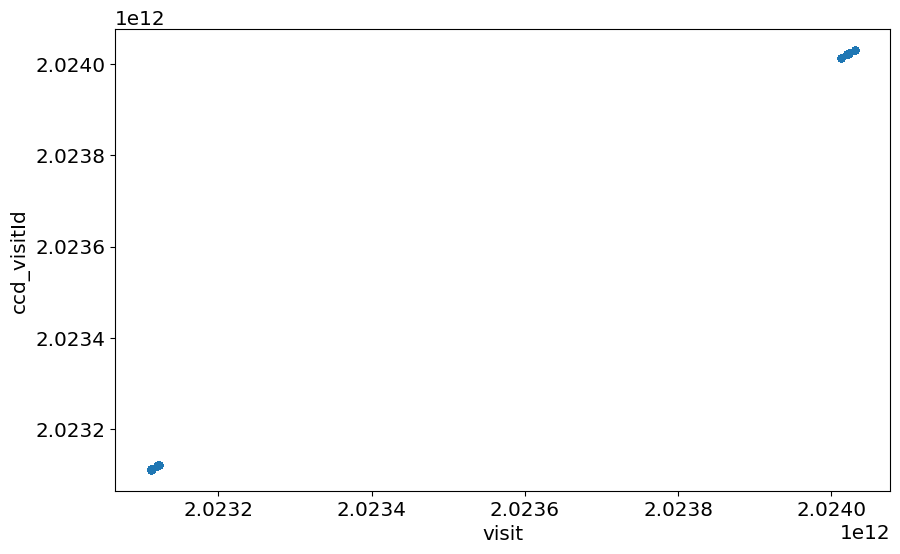

In [70]:
dataJoined.plot.scatter(x="visit",y="ccd_visitId") 

In [71]:
#dataJoined["psfSigma"] = dataJoined.apply(lambda x: psfSigmaDict[x["visit"]], axis=1)
#dataJoined["skyBg"] = dataJoined.apply(lambda x: skyBgDict[x["visit"]], axis=1)
#dataJoined["expTime"] = dataJoined.apply(lambda x: expTimeDict[x["visit"]], axis=1)
#dataJoined["expMidptMjd"] = dataJoined.apply(lambda x: expMidptMjdDict[x["visit"]], axis=1)
#dataJoined["nSource"] = dataJoined.apply(lambda x: nSourceDict[x["visit"]], axis=1)
#dataJoined["medianE"] = dataJoined.apply(lambda x: medianEDict[x["visit"]], axis=1)
#dataJoined["psfStarScaledDeltaSizeScatter"] = dataJoined.apply(lambda x: psfStarScaledDeltaSizeScatterDict[x["visit"]], axis=1)
#dataJoined["astromOffsetStd"] = dataJoined.apply(lambda x: astromOffsetStdDict[x["visit"]], axis=1)
#dataJoined["psfTraceRadiusDelta"] = dataJoined.apply(lambda x: psfTraceRadiusDeltaDict[x["visit"]], axis=1)

# I add the airmass and zero-point I want to keep here
#dataJoined["zeroPoint"] = dataJoined.apply(lambda x: zeroPointDict[x["visit"]], axis=1)
#dataJoined["localPhotoCalib"] = dataJoined.apply(lambda x: localPhotoCalibDict[x["visit"]], axis=1)
#dataJoined["airmass"] = dataJoined.apply(lambda x: airmassDict[x["visit"]], axis=1)
#dataJoined["seeing"] = dataJoined.apply(lambda x: seeingDict[x["visit"]], axis=1)
#dataJoined["DZP"] = dataJoined.apply(lambda x: DZPDict[x["visit"]], axis=1)

matchedObjIdList = list(set(dataJoined["obj_index"]))

In [72]:
matchedObjIdList = list(set(dataJoined["obj_index"]))

In [73]:
dataJoined[dataJoined.index == 0]

,sourceId,psfFlux,psfFluxErr,psfFlux_flag,psfFlux_apCorr,psfFlux_apCorrErr,extendedness,detect_isPrimary,deblend_skipped,gaussianFlux,gaussianFluxErr,gaussianFlux_flag,localPhotoCalib,localPhotoCalibErr,localPhotoCalib_flag,index,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index,psfSn,psfMag,psfMagErr,apFlux_35_0_calFlux,apFlux_35_0_calFluxErr,apFlux_35_0_calMag,apFlux_35_0_calMagErr,psfInstMag,psfGausFluxRatio,ccd_ccdVisitId,ccd_visitId,ccd_band,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,ccd_detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,airmass,medianE,dra,ddec
0,179300073413279749,1.573370e+06,12747.629058,False,1.01918,0.0,0.0,True,False,1.610028e+06,16299.16107,False,44.702317,0.081973,False,4,2023121500478,0,122.61631,-36.190488,SDSSz_65mm~empty,z,35957.22677,617.848502,3577.161135,50.744859,37554.299549,870.65158,False,0.285867,False,4,526,123.424505,15.907923,0.008797,1.607371e+06,27619.259376,15.884709,0.018656,20.033748,0.977231,42748468736,2023121500478,z,21.000441,27.28923,4.217063,13.336939,8.06057,0.027859,0.011082,62,0.000751,-0.000534,0.020873,0.013381,0.0073,0.07464,0.017815,0.618124,2102.7854,0.285962,0.056232,2.249392,0.07536,-36.139215,0,0.950443,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496868,-36.086718,1.071148,0.000921,0.051613,-0.051273


## The association between the independent sources is done through the object index 

- for plotting the repeatability

In [74]:
# Compute repeatability related values per object/object group and add
# them inplace to the dataJoined DataFrame.
psfMagDiffMmagDfList = []
psfMagStdMmagAll = []
psfMagStdMmagDict = {}
psfMagDiffChiDfList = []
psfSnAll = []
raDiffMasDfList = []
decDiffMasDfList = []
raCosDecDiffMasDfList = []
objRaDegList = []
objDecDegList = []
raStdMasAll = []
decStdMasAll = []
raCosDecStdMasAll = []
objDataList = []

# loop on objects
for objIndex in matchedObjIdList:
    # select sources corresponding to that object
    objData = dataJoined[dataJoined["obj_index"] == objIndex]
    psfMag = objData["psfMag"]
    psfMagErr = objData["psfMagErr"]

    # average flux over all visits
    clippedMeanMagArray = scipy.stats.sigmaclip(psfMag, low=3.0, high=3.0).clipped
    clippedMeanMag = np.mean(clippedMeanMagArray)
    clippedMeanMagErr = np.std(clippedMeanMagArray)/np.sqrt(len(clippedMeanMagArray))

    # array of difference between flux an clipped mean average
    psfMagDiffMmag = 1000*(psfMag - clippedMeanMag)
    # sigma arrays over the difference
    psfMagStdMmag = np.std(psfMagDiffMmag)
    # residuals array
    psfMagDiffChi = (psfMag - clippedMeanMag)/np.sqrt(psfMagErr**2 + clippedMeanMagErr**2)
    
    clippedMeanRaArray = scipy.stats.sigmaclip(objData["ra"], low=3.0, high=3.0).clipped
    clippedMeanRa = np.mean(clippedMeanRaArray)
    raDiffMas = (objData["ra"] - clippedMeanRa)*3600*1000
    
    clippedMeanDecArray = scipy.stats.sigmaclip(objData["dec"], low=3.0, high=3.0).clipped
    clippedMeanDec = np.mean(clippedMeanDecArray)
    decDiffMas = (objData["dec"] - clippedMeanDec)*3600*1000
    
    raCosDec = np.deg2rad(objData["ra"])*np.cos(np.deg2rad(objData["dec"]))
    clippedMeanRaCosDecArray = scipy.stats.sigmaclip(raCosDec, low=3.0, high=3.0).clipped
    clippedMeanRaCosDec = np.mean(clippedMeanRaCosDecArray)
    raCosDecDiffRad = (raCosDec - clippedMeanRaCosDec)
    raCosDecDiffMas = np.rad2deg(raCosDecDiffRad)*3600*1000

    # save for all sources of the object
    psfMagDiffMmagDfList.append(psfMagDiffMmag)
    psfMagStdMmagAll.append(psfMagStdMmag)
    psfMagDiffChiDfList.append(psfMagDiffChi)

    raDiffMasDfList.append(raDiffMas)
    decDiffMasDfList.append(decDiffMas)
    raCosDecDiffMasDfList.append(raCosDecDiffMas)
    
    objRaDegList.append(clippedMeanRa)
    objDecDegList.append(clippedMeanDec)

    raStdMas = np.std(raDiffMas)
    raStdMasAll.append(raStdMas)
    decStdMas = np.std(decDiffMas)
    decStdMasAll.append(decStdMas)
    raCosDecStdMas = np.std(raCosDecDiffMas)
    raCosDecStdMasAll.append(raCosDecStdMas)
    psfMagStdMmagDict[objIndex] = psfMagStdMmag

# concatenate over all objects - all sources
psfMagDiffMmagDf = pd.concat(psfMagDiffMmagDfList)
psfMagDiffChiDf = pd.concat(psfMagDiffChiDfList)
raDiffMasDf = pd.concat(raDiffMasDfList)
decDiffMasDf = pd.concat(decDiffMasDfList)
raCosDecDiffMasDf = pd.concat(raCosDecDiffMasDfList)

# add this common properties to each source in dataJoined
dataJoined.loc[:, "psfMagDiffMmag"] = psfMagDiffMmagDf
dataJoined.loc[:, "psfMagDiffChi"] = psfMagDiffChiDf
dataJoined.loc[:, "raDiffMas"] = raDiffMasDf
dataJoined.loc[:, "decDiffMas"] = decDiffMasDf
dataJoined.loc[:, "raCosDecDiffMas"] = raCosDecDiffMasDf

In [75]:
dataJoined[dataJoined.index == 0]

,sourceId,psfFlux,psfFluxErr,psfFlux_flag,psfFlux_apCorr,psfFlux_apCorrErr,extendedness,detect_isPrimary,deblend_skipped,gaussianFlux,gaussianFluxErr,gaussianFlux_flag,localPhotoCalib,localPhotoCalibErr,localPhotoCalib_flag,index,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index,psfSn,psfMag,psfMagErr,apFlux_35_0_calFlux,apFlux_35_0_calFluxErr,apFlux_35_0_calMag,apFlux_35_0_calMagErr,psfInstMag,psfGausFluxRatio,ccd_ccdVisitId,ccd_visitId,ccd_band,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,ccd_detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,airmass,medianE,dra,ddec,psfMagDiffMmag,psfMagDiffChi,raDiffMas,decDiffMas,raCosDecDiffMas
0,179300073413279749,1.573370e+06,12747.629058,False,1.01918,0.0,0.0,True,False,1.610028e+06,16299.16107,False,44.702317,0.081973,False,4,2023121500478,0,122.61631,-36.190488,SDSSz_65mm~empty,z,35957.22677,617.848502,3577.161135,50.744859,37554.299549,870.65158,False,0.285867,False,4,526,123.424505,15.907923,0.008797,1.607371e+06,27619.259376,15.884709,0.018656,20.033748,0.977231,42748468736,2023121500478,z,21.000441,27.28923,4.217063,13.336939,8.06057,0.027859,0.011082,62,0.000751,-0.000534,0.020873,0.013381,0.0073,0.07464,0.017815,0.618124,2102.7854,0.285962,0.056232,2.249392,0.07536,-36.139215,0,0.950443,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496868,-36.086718,1.071148,0.000921,0.051613,-0.051273,-299.807396,-6.082054,43.781819,-13.567254,17.547863


In [76]:
dataJoined.head()

,sourceId,psfFlux,psfFluxErr,psfFlux_flag,psfFlux_apCorr,psfFlux_apCorrErr,extendedness,detect_isPrimary,deblend_skipped,gaussianFlux,gaussianFluxErr,gaussianFlux_flag,localPhotoCalib,localPhotoCalibErr,localPhotoCalib_flag,index,visit,detector,ra,dec,physical_filter,band,apFlux_35_0_instFlux,apFlux_35_0_instFluxErr,x,y,apFlux_50_0_instFlux,apFlux_50_0_instFluxErr,apFlux_50_0_flag,localBackground_instFlux,localBackground_flag,source_row,obj_index,psfSn,psfMag,psfMagErr,apFlux_35_0_calFlux,apFlux_35_0_calFluxErr,apFlux_35_0_calMag,apFlux_35_0_calMagErr,psfInstMag,psfGausFluxRatio,ccd_ccdVisitId,ccd_visitId,ccd_band,zenithDistance,zeroPoint,psfSigma,skyBg,skyNoise,astromOffsetMean,astromOffsetStd,nPsfStar,psfStarDeltaE1Median,psfStarDeltaE2Median,psfStarDeltaE1Scatter,psfStarDeltaE2Scatter,psfStarDeltaSizeMedian,psfStarDeltaSizeScatter,psfStarScaledDeltaSizeScatter,psfTraceRadiusDelta,maxDistToNearestPsf,effTime,effTimePsfSigmaScale,effTimeSkyBgScale,effTimeZeroPointScale,decl,ccd_detector,seeing,skyRotation,expMidpt,expMidptMJD,expTime,obsStart,obsStartMJD,darkTime,xSize,ySize,llcra,llcdec,ulcra,ulcdec,urcra,urcdec,lrcra,lrcdec,airmass,medianE,dra,ddec,psfMagDiffMmag,psfMagDiffChi,raDiffMas,decDiffMas,raCosDecDiffMas
0,179300073413279749,1.573370e+06,12747.629058,False,1.019180,0.0,0.0,True,False,1.610028e+06,16299.161070,False,44.702317,0.081973,False,4,2023121500478,0,122.616310,-36.190488,SDSSz_65mm~empty,z,35957.226770,617.848502,3577.161135,50.744859,37554.299549,870.651580,False,0.285867,False,4,526,123.424505,15.907923,0.008797,1.607371e+06,27619.259376,15.884709,0.018656,20.033748,0.977231,42748468736,2023121500478,z,21.000441,27.28923,4.217063,13.336939,8.06057,0.027859,0.011082,62,0.000751,-0.000534,0.020873,0.013381,0.0073,0.07464,0.017815,0.618124,2102.7854,0.285962,0.056232,2.249392,0.07536,-36.139215,0,0.950443,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496868,-36.086718,1.071148,0.000921,0.051613,-0.051273,-299.807396,-6.082054,43.781819,-13.567254,17.547863
1,179300073413279764,1.731291e+06,13903.363905,False,1.011197,0.0,0.0,True,False,1.726342e+06,15850.956678,False,43.978963,0.081973,False,19,2023121500478,0,122.585459,-36.189035,SDSSz_65mm~empty,z,38141.482273,714.174432,2641.422154,117.690669,36552.223725,1007.246250,False,-0.151407,False,19,214,124.523165,15.804075,0.008719,1.677423e+06,31408.651184,15.838394,0.020330,19.912187,1.002867,42748468736,2023121500478,z,21.000441,27.28923,4.217063,13.336939,8.06057,0.027859,0.011082,62,0.000751,-0.000534,0.020873,0.013381,0.0073,0.07464,0.017815,0.618124,2102.7854,0.285962,0.056232,2.249392,0.07536,-36.139215,0,0.950443,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496868,-36.086718,1.071148,0.000921,0.020762,-0.049820,-179.439727,-4.791672,-6.094337,-3.377785,-7.230276
2,179300073413279802,1.057627e+07,33834.363546,False,1.009686,0.0,0.0,True,False,1.061815e+07,38411.119496,False,44.809530,0.081973,False,57,2023121500478,0,122.614697,-36.183513,SDSSz_65mm~empty,z,236931.399443,805.869427,3531.742458,313.696502,241060.843626,1040.035058,False,1.079774,False,57,647,312.589572,13.839169,0.003473,1.061678e+07,36110.630184,13.835017,0.003693,17.967595,0.996056,42748468736,2023121500478,z,21.000441,27.28923,4.217063,13.336939,8.06057,0.027859,0.011082,62,0.000751,-0.000534,0.020873,0.013381,0.0073,0.07464,0.017815,0.618124,2102.7854,0.285962,0.056232,2.249392,0.07536,-36.139215,0,0.950443,359.999731,2023-12-16 05:39:06.498994,60294.235492,30.0,2023-12-16 05:38:51.498994,60294.235318,30.2444,4071,3999,122.498487,-36.193057,122.632616,-36.191674,122.630816,-36.085337,122.496868,-36.086718,1.071148,0.000921,0.050000,-0.044298,-195.351720,-12.090006,34.398050,-11.925726,12.192946
3,179300073413279

## Check the correlation between the flux psf and apperture flux

### Compute DPZ

In [77]:
#dataJoined["localPhotoCalibMag"] = (dataJoined["localPhotoCalib"].values*u.nJy).to(u.ABmag).value
#dataJoined["DZP"] = dataJoined["localPhotoCalibMag"] - dataJoined["zeroPoint"]

In [78]:
dataJoined["localPhotoCalibMag"] = (dataJoined["localPhotoCalib"].values*u.nJy).to(u.ABmag).value
dataJoined["localPhotoCalibMagErr"] =   2.5/np.log(10.0)*dataJoined["localPhotoCalibErr"].values/dataJoined["localPhotoCalib"].values
dataJoined["DZP"] = dataJoined["localPhotoCalibMag"] - dataJoined["zeroPoint"]

- The goal is to understand what flux is calibrated what flux is not calibrated 

In [79]:
dataJoined_subset = dataJoined[["obj_index","sourceId","band","visit","ra","dec","psfMag","psfFlux","gaussianFlux",calibFluxCalStr,calibFluxCalMagStr,calibFluxStr,"psfFlux_apCorr",
                                "psfMagErr","psfFluxErr","gaussianFluxErr",calibFluxCalErrStr,calibFluxCalMagErrStr,calibFluxErrStr,"skyBg","zeroPoint","localPhotoCalib","localPhotoCalibMag","DZP","localPhotoCalibMagErr","x","y"]].copy()

In [80]:
dataJoined_subset.sort_values(by=["obj_index","band","visit"])

,obj_index,sourceId,band,visit,ra,dec,psfMag,psfFlux,gaussianFlux,apFlux_35_0_calFlux,apFlux_35_0_calMag,apFlux_35_0_instFlux,psfFlux_apCorr,psfMagErr,psfFluxErr,gaussianFluxErr,apFlux_35_0_calFluxErr,apFlux_35_0_calMagErr,apFlux_35_0_instFluxErr,skyBg,zeroPoint,localPhotoCalib,localPhotoCalibMag,DZP,localPhotoCalibMagErr,x,y
5670,1,178244578757837049,g,2023111500512,122.513230,-36.180948,17.032426,5.585083e+05,5.565008e+05,5.798167e+05,16.991773,26553.375999,1.010587,0.011093,5706.303743,6797.157863,11336.191391,0.021228,519.154017,2.840078,28.055309,21.835893,28.052073,-0.003237,0.001724,3961.957732,2046.783037
8316,1,178420351368167677,g,2023112000373,122.513233,-36.180937,16.995341,5.779145e+05,5.780637e+05,5.925426e+05,16.968201,27371.511238,1.021076,0.012564,6687.667838,7262.665262,11508.198374,0.021087,531.601921,5.203045,28.058723,21.648150,28.061448,0.002725,0.004197,3805.425101,2999.789965
40436,1,178983149923991860,g,2023120600232,122.513235,-36.180947,17.022433,5.636724e+05,5.738193e+05,5.758675e+05,16.999194,27295.265375,1.030830,0.011922,6189.413468,7193.755942,11207.387210,0.021130,531.213554,3.076313,28.082020,21.097706,28.089412,0.007392,0.002919,3970.076556,3204.289839
25976,1,179264657112957250,g,2023121400262,122.513226,-36.180947,17.037390,5.559604e+05,5.639564e+05,5.707058e+05,17.008969,26750.245147,1.012603,0.011449,5862.344009,6925.198567,11169.631797,0.021250,523.545389,2.928468,28.061041,21.334601,28.077289,0.016248,0.002533,3810.291928,3058.449428
26075,1,179264661407924551,g,2023121400266,122.513238,-36.180947,17.050361,5.493582e+05,5.596010e+05,5.821624e+05,16.987390,27431.515311,1.001790,0.011515,5826.110215,6496.214977,11612.825804,0.021658,547.196844,2.898449,28.063183,21.222392,28.083014,0.019831,0.001994,3254.301519,3066.812621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23675,1287,182114491394162926,y,2024030400169,122.532814,-36.107704,11.162682,1.244306e+08,1.247463e+08,1.246037e+08,11.161173,956621.510112,1.063129,0.003327,381295.880927,397656.058885,144325.859076,0.001258,1108.034944,18.040142,26.107185,130.253888,26.113023,0.005838,0.003032,3141.945707,2953.310021
20548,1287,182114502131581226,y,2024030400179,122.532817,-36.107704,11.160283,1.247058e+08,1.234379e+08,1.248158e+08,11.159326,960122.167480,1.033465,0.003866,444015.881163,458108.121463,145794.518860,0.001268,1121.497021,18.145388,26.108686,129.999916,26.115142,0.006456,0.003591,2585.006738,2967.719322
38328,1289,178455686064111639,y,2023112100513,122.519843,-36.268801,11.954165,6.002528e+07,6.227489e+07,6.151974e+07,11.927464,502283.911049,1.008694,0.005187,286739.247048,313396.844794,116338.621679,0.002053,949.858021,12.204996,26.191488,122.480012,26.179837,-0.011651,0.004776,2859.521955,158.086520
38342,1289,178455690359078930,y,2023112100517,122.519839,-36.268803,11.998707,5.761257e+07,5.704049e+07,5.855295e+07,11.981128,500350.151243,1.016557,0.003822,202810.433640,216928.688678,109069.617306,0.002022,932.028104,12.294806,26.237740,117.023958,26.229313,-0.008427,0.003232,2303.815468,167.764016


In [81]:
dataJoined_subset_g = dataJoined_subset[dataJoined_subset["band"] == "g"]
dataJoined_subset_r = dataJoined_subset[dataJoined_subset["band"] == "r"]
dataJoined_subset_i = dataJoined_subset[dataJoined_subset["band"] == "i"]
dataJoined_subset_z = dataJoined_subset[dataJoined_subset["band"] == "z"]
dataJoined_subset_y = dataJoined_subset[dataJoined_subset["band"] == "y"]

### Histogram on calibration

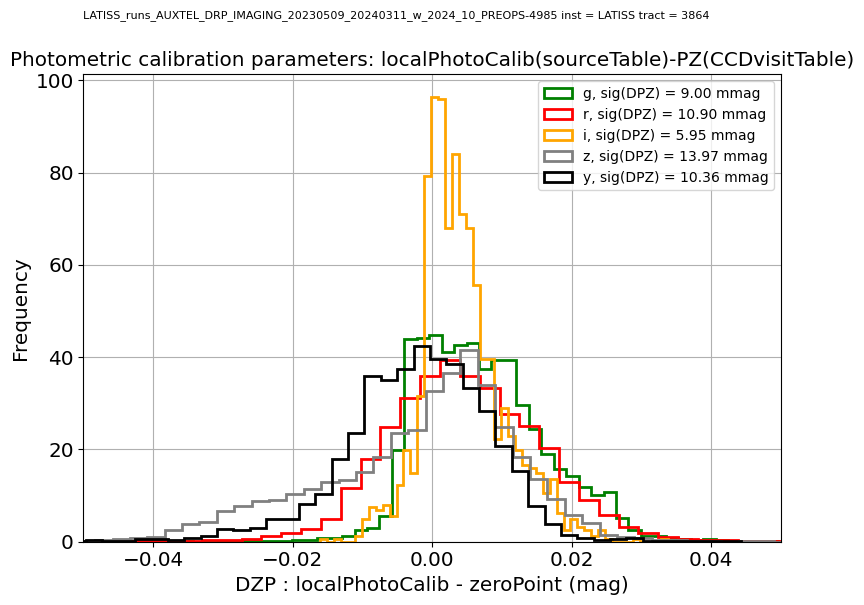

In [82]:
all_dpz_std = []
all_labels = []
fig,ax = plt.subplots(1,1,figsize=(8,6))

std = dataJoined_subset_g["DZP"].std()*1000
label = f"g, sig(DPZ) = {std:.2f} mmag"
all_dpz_std.append(std)
all_labels.append(label) 
dataJoined_subset_g["DZP"].plot.hist(bins=50,histtype="step",density=True,ax=ax,color="g",lw=2,label=label)

std = dataJoined_subset_r["DZP"].std()*1000
label = f"r, sig(DPZ) = {std:.2f} mmag"
all_dpz_std.append(std)
all_labels.append(label) 
dataJoined_subset_r["DZP"].plot.hist(bins=50,histtype="step",density=True,ax=ax,color="r",lw=2,label=label)

std = dataJoined_subset_i["DZP"].std()*1000
label = f"i, sig(DPZ) = {std:.2f} mmag"
all_dpz_std.append(std)
all_labels.append(label) 
dataJoined_subset_i["DZP"].plot.hist(bins=50,histtype="step",density=True,ax=ax,color="orange",lw=2,label=label)

std = dataJoined_subset_z["DZP"].std()*1000
label = f"z, sig(DPZ) = {std:.2f} mmag"
all_dpz_std.append(std)
all_labels.append(label) 
dataJoined_subset_z["DZP"].plot.hist(bins=50,histtype="step",density=True,ax=ax,color="grey",lw=2,label=label)

std = dataJoined_subset_y["DZP"].std()*1000
label = f"y, sig(DPZ) = {std:.2f} mmag"
all_dpz_std.append(std)
all_labels.append(label) 
dataJoined_subset_y["DZP"].plot.hist(bins=50,histtype="step",density=True,ax=ax,color="k",lw=2,label=label)

ax.set_xlabel("DZP : localPhotoCalib - zeroPoint (mag)")
ax.set_xlim(-0.05,0.05)
ax.grid()
ax.legend()
ax.set_title("Photometric calibration parameters: localPhotoCalib(sourceTable)-PZ(CCDvisitTable)")
plt.suptitle(suptitle,y=1.0,fontsize=8)
plt.tight_layout()

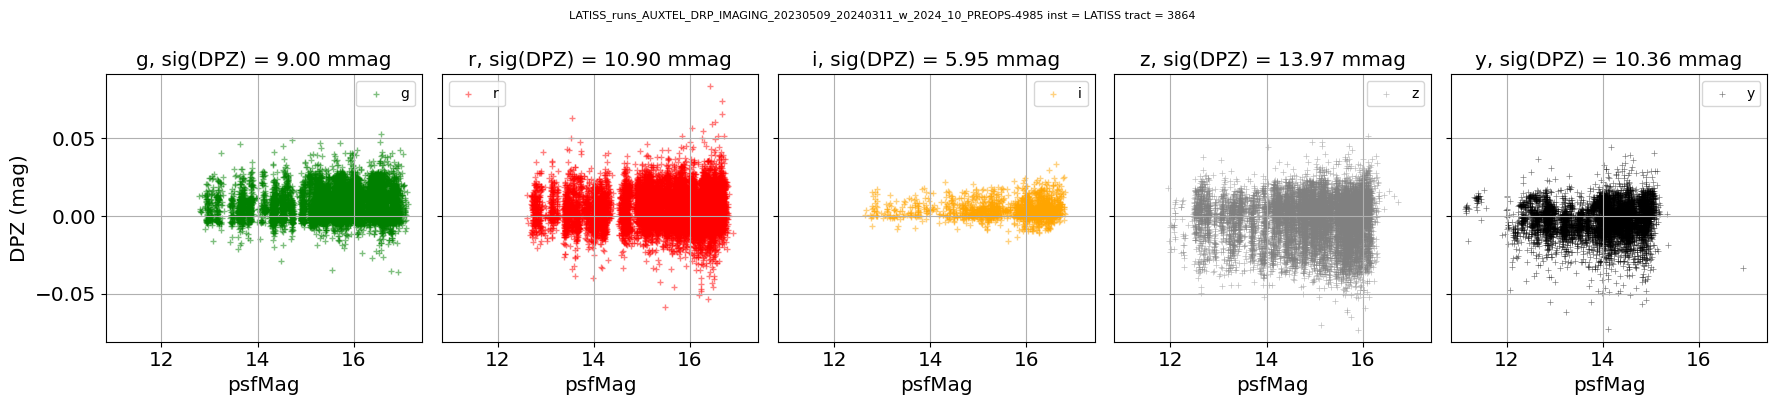

In [83]:
fig,axs = plt.subplots(1,5,figsize=(18,4),sharex=True,sharey=True)
ax1,ax2,ax3,ax4,ax5 =axs
dataJoined_subset_g.plot.scatter(x="psfMag",y="DZP",ax=ax1,color="g",marker="+",lw=1,label="g",title=all_labels[0],grid=True,alpha=0.5)
dataJoined_subset_r.plot.scatter(x="psfMag",y="DZP",ax=ax2,color="r",marker="+",lw=1,label="r",title=all_labels[1],grid=True,alpha=0.5)
dataJoined_subset_i.plot.scatter(x="psfMag",y="DZP",ax=ax3,color="orange",marker="+",lw=1,label="i",title=all_labels[2],grid=True,alpha=0.5)
dataJoined_subset_z.plot.scatter(x="psfMag",y="DZP",ax=ax4,color="grey",marker="+",lw=0.5,label="z",title=all_labels[3],grid=True,alpha=0.5)
dataJoined_subset_y.plot.scatter(x="psfMag",y="DZP",ax=ax5,color="k",marker="+",lw=0.5,label="y",title=all_labels[4],grid=True,alpha=0.5)
ax1.set_ylabel("DPZ (mag)")
plt.suptitle(suptitle,y=1.0,fontsize=8)
plt.tight_layout()

In [84]:
all_localPhotoCalibMagErr_aver = []
all_labels = []

aver = dataJoined_subset_g["localPhotoCalibMagErr"].mean()*1000
label = f"g, aver(locPCalErr) = {aver:.2f} mmag"
all_localPhotoCalibMagErr_aver.append(std)
all_labels.append(label) 

aver = dataJoined_subset_r["localPhotoCalibMagErr"].mean()*1000
label = f"r, aver(locPCalErr) = {aver:.2f} mmag"
all_localPhotoCalibMagErr_aver.append(std)
all_labels.append(label) 

aver = dataJoined_subset_i["localPhotoCalibMagErr"].mean()*1000
label = f"i, aver(locPCalErr) = {aver:.2f} mmag"
all_localPhotoCalibMagErr_aver.append(std)
all_labels.append(label) 

aver = dataJoined_subset_z["localPhotoCalibMagErr"].mean()*1000
label = f"z, aver(locPCalErr) = {aver:.2f} mmag"
all_localPhotoCalibMagErr_aver.append(std)
all_labels.append(label) 

aver = dataJoined_subset_y["localPhotoCalibMagErr"].mean()*1000
label = f"y, aver(locPCalErr) = {aver:.2f} mmag"
all_localPhotoCalibMagErr_aver.append(std)
all_labels.append(label) 


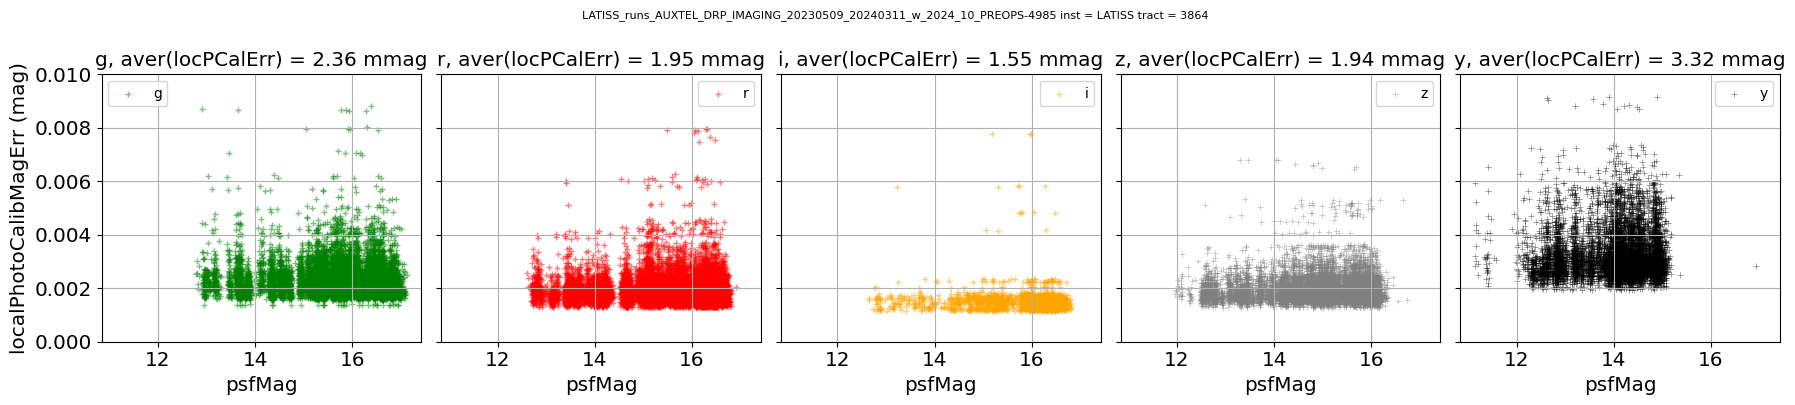

In [85]:
fig,axs = plt.subplots(1,5,figsize=(18,4),sharex=True,sharey=True)
ax1,ax2,ax3,ax4,ax5 =axs
dataJoined_subset_g.plot.scatter(x="psfMag",y="localPhotoCalibMagErr",ax=ax1,color="g",marker="+",lw=1,label="g",title=all_labels[0],grid=True,alpha=0.5)
dataJoined_subset_r.plot.scatter(x="psfMag",y="localPhotoCalibMagErr",ax=ax2,color="r",marker="+",lw=1,label="r",title=all_labels[1],grid=True,alpha=0.5)
dataJoined_subset_i.plot.scatter(x="psfMag",y="localPhotoCalibMagErr",ax=ax3,color="orange",marker="+",lw=1,label="i",title=all_labels[2],grid=True,alpha=0.5)
dataJoined_subset_z.plot.scatter(x="psfMag",y="localPhotoCalibMagErr",ax=ax4,color="grey",marker="+",lw=0.5,label="z",title=all_labels[3],grid=True,alpha=0.5)
dataJoined_subset_y.plot.scatter(x="psfMag",y="localPhotoCalibMagErr",ax=ax5,color="k",marker="+",lw=0.5,label="y",title=all_labels[4],grid=True,alpha=0.5)
ax1.set_ylabel("localPhotoCalibMagErr (mag)")
ax1.set_ylim(0.,0.01)
plt.suptitle(suptitle,y=1.0,fontsize=8)
plt.tight_layout()

## Non uniformity on CCD

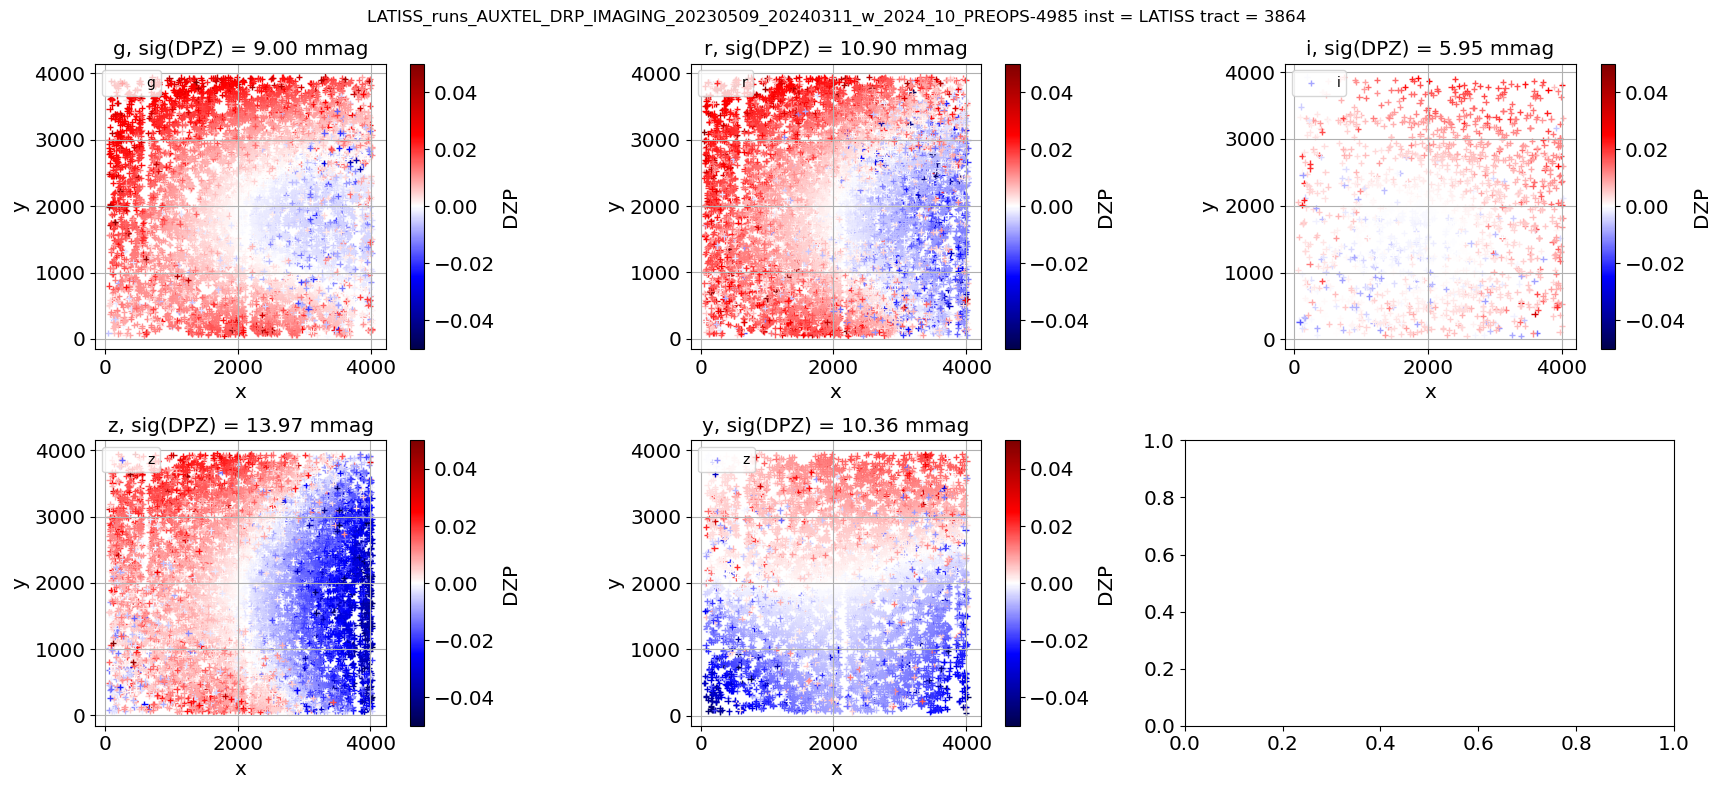

In [86]:
fig,axs = plt.subplots(2,3,figsize=(18,8))
ax1,ax2,ax3,ax4,ax5 = axs[0,0], axs[0,1],axs[0,2],axs[1,0],axs[1,1]

std = dataJoined_subset_g["DZP"].std()*1000
label = f"g, sig(DPZ) = {std:.2f} mmag"
dataJoined_subset_g.plot.scatter(x="x",y="y",ax=ax1,marker="+",lw=1,c="DZP",cmap="seismic",label="g",title=label,grid=True,alpha=1,colorbar="True",vmin=-0.05,vmax=0.05)
ax1.set_aspect("equal")

std = dataJoined_subset_r["DZP"].std()*1000
label = f"r, sig(DPZ) = {std:.2f} mmag"
dataJoined_subset_r.plot.scatter(x="x",y="y",ax=ax2,marker="+",lw=1,c="DZP",cmap="seismic",label="r",title=label,grid=True,alpha=1,colorbar="True",vmin=-0.05,vmax=0.05)
ax2.set_aspect("equal")

std = dataJoined_subset_i["DZP"].std()*1000
label = f"i, sig(DPZ) = {std:.2f} mmag"
dataJoined_subset_i.plot.scatter(x="x",y="y",ax=ax3,marker="+",lw=1,c="DZP",cmap="seismic",label="i",title=label,grid=True,alpha=1,colorbar="True",vmin=-0.05,vmax=0.05)
ax3.set_aspect("equal")

std = dataJoined_subset_z["DZP"].std()*1000
label = f"z, sig(DPZ) = {std:.2f} mmag"
dataJoined_subset_z.plot.scatter(x="x",y="y",ax=ax4,marker="+",lw=1,c="DZP",cmap="seismic",label="z",title=label,grid=True,alpha=1,colorbar="True",vmin=-0.05,vmax=0.05)
ax4.set_aspect("equal")


std = dataJoined_subset_y["DZP"].std()*1000
label = f"y, sig(DPZ) = {std:.2f} mmag"
dataJoined_subset_y.plot.scatter(x="x",y="y",ax=ax5,marker="+",lw=1,c="DZP",cmap="seismic",label="z",title=label,grid=True,alpha=1,colorbar="True",vmin=-0.05,vmax=0.05)
ax5.set_aspect("equal")


plt.suptitle(suptitle)
plt.tight_layout()

### Check visit by visit in each filter

In [87]:
NROWS = 10
NCOLS = 3
NIMGS = NROWS*NCOLS
index0 = 0

#### In green filter

In [88]:
listofvisits = dataJoined_subset_g["visit"].unique()

In [ ]:
listofvisits 